In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
import plotly.graph_objs as go
import io, numpy as np
from contextlib import redirect_stdout

# -----------------------------
# Parameters
# -----------------------------

if True:  # purely to create a foldable block

    # Ego-agent boundary conditions
    x0 = np.array([0.0, 0.0, 0.0])
    v0 = np.array([0.0, 0.0, 0.0])
    a0 = np.array([0.0, 0.0, 0.0])
    xf = np.array([5.0, 5.0, 0.0])
    vf = np.array([0.0, 0.0, 0.0])
    af = np.array([0.0, 0.0, 0.0])

    # Obstacle boundary conditions & time

    # Obstacle 0
    x0_obs0 = np.array([1.0, 3.0, 1.0])
    v0_obs0 = np.array([-0.3, 0.3, 0.0])
    a0_obs0 = np.array([0.0, 0.0, 0.0])
    xf_obs0 = np.array([5.0, 5.0, 1.0])
    vf_obs0 = np.array([0.0, 0.0, 0.0])
    af_obs0 = np.array([0.0, 0.0, 0.0])
    T_obs0 = 8.0

    # Obstacle 1
    x0_obs1 = np.array([0.0, 0.5, 0.0])
    v0_obs1 = np.array([0.5, 0.0, 0.0])
    a0_obs1 = np.array([0.0, 0.0, 0.0])
    xf_obs1 = np.array([6.0, 5.0, -0.5])
    vf_obs1 = np.array([0.0, 0.0, 0.0])
    af_obs1 = np.array([0.0, 0.0, 0.0])
    T_obs1 = 8.0

    # List of obstacles
    obstacles = [
        [x0_obs0, v0_obs0, a0_obs0, xf_obs0, vf_obs0, af_obs0, T_obs0],
        [x0_obs1, v0_obs1, a0_obs1, xf_obs1, vf_obs1, af_obs1, T_obs1],
    ]
    # obstacles = []

    # Static box for visualization
    box_center = np.array([3.5, 1.5, 1.0])
    box_size = np.array([2.0, 2.0, 2.0])  # size of the box in x, y, z dimensions

    # Global waypoints
    global_wps = np.array([x0, 
                        [0.0, 2.0, 0.0], 
                        [0.0, 4.0, 0.0], 
                        xf])

    # Number of segment M
    M = len(global_wps) - 1

    # Number of decision variables (9 * (M - 2) + M) - for each points we have 9 variables (3 for position, 3 for velocity, 3 for acceleration) but we exclude the start and goal points since they are already given and  for the segment durations
    K = 9 * (M + 1) + M 
    K_cp = 9 * (M + 1)  # number of free control points (excluding start and goal)
    K_sig = M  # number of segment durations (σ_r)

    # Static constraints
    A_stat = [
        np.array([[ -0.5, -0.0, 0.1]]),   # was [-0.5, 0.0, 0.1], b=-0.5
        np.array([[ -0.5, 0.3, 0.01]]),   # was [-0.5, 0.5, 0.1], b= 1.0
        np.array([[ 0.0, 0.5, 0.1]]),   # was [ 0.0, 0.5, 0.1], b= 2.0
    ]

    b_stat = [
        np.array([-0.5]),                 # was -0.5
        np.array([-0.1]),                 # was  1.0
        np.array([2.0]),                 # was  2.0
    ]

    def check_inside(A_list, b_list, x):
        for s,(A,b) in enumerate(zip(A_list, b_list)):
            h = A @ x - b
            print(f"seg {s}: min h = {h.min(): .6f} >= 0.0")

    # example:
    # for x_in in global_wps:
    #     print(f"Checking point {x_in}")
    #     check_inside(A_stat, b_stat, x_in)

    assert len(A_stat) == M, "Number of segments M does not match the number of static constraints."
    assert len(b_stat) == M, "Number of segments M does not match the number of static constraints."

    # Generate perturbed waypoints
    joint_indices = [i for i in range(1, M)]  # indices of the joints to perturb
    num_samples = 8  # number of perturbed waypoint sets to generate
    r_max = 1.0  # radius bounds for perturbation

    # Generate perturbed waypoints
    constraint_sets = []
    for idx in joint_indices:
        sets = [(A_stat[idx - 1], b_stat[idx - 1]), (A_stat[idx], b_stat[idx])]
        constraint_sets.append(sets)

    # Optimization parameters
    kappa = 30  # integral resolution per segment for numerical integration
    mu = 1e-2  # hinge loss parameter
    V_max = 2.0  # max velocity
    Omega_max = 0.5  # max body rate
    tilt_max_rad = np.deg2rad(10.0)  # max tilt angle in radians
    f_min = 0.0  # min thrust
    f_max = 10.0  # max thrust
    m = 1.0  # mass
    g = 9.81  # gravity

    time_weight = 1.0
    jerk_weight = 1.0
    stat_weight = 1.0
    dyn_constr_vel_weight = 1.0
    dyn_constr_bodyrate_weight = 1.0
    dyn_constr_tilt_weight = 1.0
    dyn_constr_thrust_weight = 1.0

    orient_smooth_weight = 0.10   # w_orient: always-on body-rate smoothing
    tilt_bias_weight =     0.02   # w_tilt_bias: small bias toward upright
    tvar_weight =          0.10   # w_tvar: time-variance penalty
    Tmin_weight =          1.00   # w_Tmin: soft lower bound on each Ts
    Tmin_plan =            0.15   # [s] soft minimum segment time

    bfgs_max_iter = 100
    Co = 2.0  # e.g. 0.1 m
    Cw = 1.0  # desired clearance for reciprocal collision avoidance
    second_to_last_vel_scale = 0.9  # scale for the second to last velocity vector in the optimization

    plot_samples_per_seg = 50

    _e3 = np.array([0.0, 0.0, 1.0])

    # Promote constr violations to debug gradient
    promote_constr_violations = True

In [8]:
# ------------------------------
# Helper functions
# ------------------------------

if True:  # purely to create a foldable block

    def phi_scalar(x, mu):
        # Always return a true Python float (handles numpy scalars/1-D arrays too)
        return float(smoothed_l1(float(x), mu))

    def gcopter_T_map(tau):
        """
        T(τ) = { 0.5 τ^2 + τ + 1,                τ >= 0
            { 1 / (0.5 τ^2 - τ + 1),          τ <  0
        """
        tau = np.asarray(tau, dtype=float)
        T = np.empty_like(tau)
        pos = tau >= 0.0
        # τ >= 0 branch
        T[pos]  = 0.5 * tau[pos]**2 + tau[pos] + 1.0
        # τ < 0 branch
        den     = 0.5 * tau[~pos]**2 - tau[~pos] + 1.0
        T[~pos] = 1.0 / den
        return T

    def gcopter_dT_dtau(tau):
        """
        dT/dτ = { τ + 1,                           τ >= 0
                { (1 - τ) / (0.5 τ^2 - τ + 1)^2,   τ <  0
        """
        tau = np.asarray(tau, dtype=float)
        d = np.empty_like(tau)
        pos = tau >= 0.0
        d[pos] = tau[pos] + 1.0
        den    = 0.5 * tau[~pos]**2 - tau[~pos] + 1.0
        d[~pos]= (1.0 - tau[~pos]) / (den*den)
        return d

    def gcopter_tau_from_T(T):
        """
        Inverse for completeness:
        τ = sqrt(2T-1) - 1      if T >= 1
        τ = 1 - sqrt(2/T - 1)   if T < 1
        """
        T = np.asarray(T, dtype=float)
        tau = np.empty_like(T)
        ge1 = T >= 1.0
        tau[ge1]  = np.sqrt(2.0*T[ge1] - 1.0) - 1.0
        tau[~ge1] = 1.0 - np.sqrt(2.0/T[~ge1] - 1.0)
        return tau

    def smoothed_l1(x, mu):
        """
        φ_mu(x) = 0                 if x <= 0
                x^2/(2μ)          if 0 < x < μ
                x - μ/2           if x >= μ
        Vectorized over x.
        """
        x = np.asarray(x)
        mu = float(mu)
        out = np.zeros_like(x, dtype=float)
        mask1 = (x > 0) & (x < mu)
        mask2 = x >= mu
        out[mask1] = (x[mask1] ** 2) / (2.0 * mu)
        out[mask2] = x[mask2] - 0.5 * mu
        return out

    def _bernstein(n, s):
        from math import comb
        j = np.arange(n+1)
        return np.array([comb(n,k)*(s**k)*((1-s)**(n-k)) for k in j], dtype=float)

    def _safe_norm(x, eps=1e-12):
        n = np.linalg.norm(x, axis=-1, keepdims=True)
        return np.clip(n, eps, None)

    def bodyrate_tilt_thrust_from(a, j, yaw_ref=0.0, mass=None, g=None):
        """
        From acceleration a(t), jerk j(t): compute
        - b3 (thrust direction), tilt cosθ = e3·b3
        - body rate vector ω (approx; ψ_dot=0)
        - thrust magnitude f = m*||a + g e3||
        Returns (omega, cos_tilt, thrust) with shapes (N,3), (N,), (N,)
        """
        m = 1.0 if mass is None else float(mass)
        gval = 9.81 if g is None else float(g)

        a = np.asarray(a)
        j = np.asarray(j)
        N = a.shape[0]

        n = a + gval * _e3  # (N,3)
        nmag = _safe_norm(n)  # (N,1)
        b3 = n / nmag  # (N,3)
        cos_t = b3 @ _e3  # (N,)

        # b3dot = (I - b3 b3^T) * (j / ||n||)
        # compute projection efficiently
        proj = j - (np.sum(j * b3, axis=1, keepdims=True)) * b3
        b3dot = proj / nmag

        # Build b1,b2 with constant yaw_ref (ψ_dot = 0)
        cpsi, spsi = np.cos(yaw_ref), np.sin(yaw_ref)
        b1c = np.array([cpsi, spsi, 0.0])

        # Handle degeneracy when b3 ~ ±b1c
        s = np.cross(b3, b1c)  # (N,3)
        sn = _safe_norm(s)  # (N,1)
        bad = sn[:, 0] < 1e-6
        if np.any(bad):
            # swap reference axis for those samples
            b1c_alt = np.array([0.0, 1.0, 0.0])
            s_alt = np.cross(b3[bad], b1c_alt)
            s[bad] = s_alt
            sn[bad] = _safe_norm(s_alt)

        b2 = s / sn
        b1 = np.cross(b2, b3)

        # ω has no yaw component when ψ̇=0:
        # b3dot = ω × b3  => components:
        #   ω1 = - b2·b3dot,  ω2 = b1·b3dot,  ω3 = 0
        w1 = -np.sum(b2 * b3dot, axis=1)
        w2 = np.sum(b1 * b3dot, axis=1)
        w3 = np.zeros_like(w1)
        omega = np.stack([w1, w2, w3], axis=1)  # (N,3)

        thrust = m * nmag[:, 0]  # (N,)
        return omega, cos_t, thrust

    def reconstruct(z):
        """
        Reconstruct P, V, A, CP, T from
        z = [p0, vhat0, ahat0, …, pM, vhatM, ahatM, tau0…tau_{M-1}]
        Uses GCOPTER T-map and *averaged* knot-time decoding:
            V_k = vhat_k / Tbar[k],   A_k = ahat_k / Tbar[k]^2
        where:
            Tbar[0]   = T[0]
            Tbar[k]   = 0.5*(T[k-1] + T[k])   for k=1..M-1
            Tbar[M]   = T[M-1]
        If global boundary conditions (x0,v0,a0, xf,vf,af) exist, they override z.
        Returns:
        P (M+1,3), V (M+1,3), A (M+1,3), CP (M,6,3), T (M,)
        """
        z = np.asarray(z, dtype=float)
        L = z.shape[0]
        M = (L - 9) // 10
        assert L == 9 * (M + 1) + M, f"Inconsistent z length: L={L}, M inferred={M}"

        pvh_all = z[: 9 * (M + 1)].reshape((M + 1, 9))
        tau = z[9 * (M + 1) :]
        T = gcopter_T_map(tau)  # (M,)

        # Decode P, V, A from (p, vhat, ahat) using averaged knot times
        P = pvh_all[:, 0:3].copy()
        Vhat = pvh_all[:, 3:6].copy()
        Ahat = pvh_all[:, 6:9].copy()

        Tbar = np.empty(M + 1, dtype=float)
        if M == 1:
            # trivial 2-knot case
            Tbar[0] = T[0]
            Tbar[1] = T[0]
        else:
            Tbar[0] = T[0]
            Tbar[1:M] = 0.5 * (T[:-1] + T[1:])
            Tbar[M] = T[-1]

        V = Vhat / Tbar[:, None]
        A = Ahat / (Tbar[:, None] ** 2)

        # Optional: enforce boundary conditions if provided as globals
        if all(name in globals() for name in ("x0", "v0", "a0", "xf", "vf", "af")):
            P[0], V[0], A[0] = x0, v0, a0
            P[-1], V[-1], A[-1] = xf, vf, af

        # Hermite -> Bezier control points
        CP = np.zeros((M, 6, 3), dtype=float)
        for s in range(M):
            Ts = T[s]
            p0, v0s, a0s = P[s], V[s], A[s]
            p1, v1s, a1s = P[s + 1], V[s + 1], A[s + 1]
            CP[s, 0] = p0
            CP[s, 1] = p0 + (Ts / 5.0) * v0s
            CP[s, 2] = p0 + (2.0 * Ts / 5.0) * v0s + (Ts**2 / 20.0) * a0s
            CP[s, 3] = p1 - (2.0 * Ts / 5.0) * v1s + (Ts**2 / 20.0) * a1s
            CP[s, 4] = p1 - (Ts / 5.0) * v1s
            CP[s, 5] = p1

        return P, V, A, CP, T

    def eval_traj(z, num_samples):
        """
        Evaluate positions at uniform time over the whole trajectory with new z layout
        z = [p0,vhat0,ahat0, ..., pM,vhatM,ahatM,  tau0, ..., tau_{M-1}]
        """
        P, V, A, CP, T = reconstruct(z)
        M = T.shape[0]
        ends = np.cumsum(T)
        total_time = float(ends[-1])

        # precompute per-seg coeffs
        coeffs = []
        for i in range(M):
            cx, cy, cz = fit_quintic(P[i], V[i], A[i], P[i + 1], V[i + 1], A[i + 1], T[i])
            coeffs.append((cx, cy, cz))

        times = np.linspace(0.0, total_time, num_samples)
        pts = np.zeros((num_samples, 3), dtype=float)
        for j, t in enumerate(times):
            seg = min(np.searchsorted(ends, t, side="right"), M - 1)
            t0 = 0.0 if seg == 0 else ends[seg - 1]
            tl = min(t - t0, T[seg])
            cx, cy, cz = coeffs[seg]
            pts[j, 0] = sum(cx[k] * tl**k for k in range(6))
            pts[j, 1] = sum(cy[k] * tl**k for k in range(6))
            pts[j, 2] = sum(cz[k] * tl**k for k in range(6))
        return pts, times

    def eval_traj_and_derivs(z, num_samples_per_seg):
        """
        Returns positions, velocities, accelerations, jerks, and timestamps,
        sampled uniformly (endpoint=False) in each segment with new z layout.
        """
        P, V, A, CP, T = reconstruct(z)
        M = T.shape[0]

        all_pos, all_vel, all_acc, all_jerk, all_t = [], [], [], [], []
        t_offset = 0.0
        for i in range(M):
            Ti = T[i]
            cx, cy, cz = fit_quintic(P[i], V[i], A[i], P[i + 1], V[i + 1], A[i + 1], Ti)
            c1x, c1y, c1z = (
                _derivative_coeffs(cx, 1),
                _derivative_coeffs(cy, 1),
                _derivative_coeffs(cz, 1),
            )
            c2x, c2y, c2z = (
                _derivative_coeffs(cx, 2),
                _derivative_coeffs(cy, 2),
                _derivative_coeffs(cz, 2),
            )
            c3x, c3y, c3z = (
                _derivative_coeffs(cx, 3),
                _derivative_coeffs(cy, 3),
                _derivative_coeffs(cz, 3),
            )

            tloc = np.linspace(0.0, Ti, num_samples_per_seg, endpoint=False)
            all_pos.append(f_poly(tloc, (cx, cy, cz)))
            all_vel.append(f_poly(tloc, (c1x, c1y, c1z)))
            all_acc.append(f_poly(tloc, (c2x, c2y, c2z)))
            all_jerk.append(f_poly(tloc, (c3x, c3y, c3z)))
            all_t.append(t_offset + tloc)
            t_offset += Ti

        return (
            np.vstack(all_pos),
            np.vstack(all_vel),
            np.vstack(all_acc),
            np.vstack(all_jerk),
            np.hstack(all_t),
        )

    def fit_quintic(x0, v0, a0, xf, vf, af, T):
        """
        Fit a single-segment quintic in R³; returns (cx, cy, cz) each length-6.
        """
        A = np.zeros((6, 6))
        bx = np.zeros(6)
        by = np.zeros(6)
        bz = np.zeros(6)
        # p(0)=x0, p'(0)=v0, p''(0)=a0
        A[0, 0] = 1
        bx[0], by[0], bz[0] = x0
        A[1, 1] = 1
        bx[1], by[1], bz[1] = v0
        A[2, 2] = 2
        bx[2], by[2], bz[2] = a0
        # p(T)=xf
        for i in range(6):
            A[3, i] = T**i
        bx[3], by[3], bz[3] = xf
        # p'(T)=vf
        for i in range(1, 6):
            A[4, i] = i * T ** (i - 1)
        bx[4], by[4], bz[4] = vf
        # p''(T)=af
        for i in range(2, 6):
            A[5, i] = i * (i - 1) * T ** (i - 2)
        bx[5], by[5], bz[5] = af

        cx = np.linalg.solve(A, bx)
        cy = np.linalg.solve(A, by)
        cz = np.linalg.solve(A, bz)
        return cx, cy, cz

    def f_obs_poly(t, c_x, c_y, c_z):
        """
        Dynamic obstacle polynomial in R³.
        """
        t = np.array(t)
        px = sum(c_x[i] * t**i for i in range(6))
        py = sum(c_y[i] * t**i for i in range(6))
        pz = sum(c_z[i] * t**i for i in range(6))
        return np.vstack([px, py, pz]).T

    def sample_systematic_perturbed_waypoints(
        global_wps, joint_indices, r_max, constraint_sets
    ):
        """
        Perturb joint waypoints by sampling 8 directions in the bisector-plane,
        always at distance r_max, and respecting *any* number of linear constraints:
        A @ pt > b, where A may be (3,) or (n,3) and b may be scalar or (n,).

        Args:
        global_wps     : list or (K×3) array of original waypoints
        joint_indices  : list of indices into global_wps to perturb
        r_max          : scalar radius for perturbation
        constraint_sets: list of length len(joint_indices), each a list of
                        tuples (A, b) where
                            • A is np.ndarray of shape (3,) or (n_planes,3)
                            • b is float or np.ndarray of shape (n_planes,)

        Returns:
        samples : np.ndarray of shape (M,K,3), with M≤8 feasible perturbed sets
        """
        # 1) build per-joint bisector bases
        bases = []
        for idx in joint_indices:
            P_prev, P, P_next = global_wps[idx - 1], global_wps[idx], global_wps[idx + 1]
            d1 = P - P_prev
            d1 /= np.linalg.norm(d1)
            d2 = P_next - P
            d2 /= np.linalg.norm(d2)
            pn = np.cross(d1, d2)
            if np.linalg.norm(pn) < 1e-8:
                pn = np.cross(d1, [1, 0, 0])
            pn /= np.linalg.norm(pn)
            bis_n = d1 + d2
            if np.linalg.norm(bis_n) < 1e-8:
                bis_n = d1
            bis_n /= np.linalg.norm(bis_n)
            v_bis = np.cross(bis_n, pn)
            v_bis /= np.linalg.norm(v_bis)
            bases.append((pn, v_bis))

        # 2) sample 8 equally-spaced angles
        angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
        samples = []

        # 3) for each angle, try perturbing *all* joints
        for φ in angles:
            cand = [p.copy() for p in global_wps]
            feasible = True

            for j, idx in enumerate(joint_indices):
                pn, v_bis = bases[j]
                direction = np.cos(φ) * pn + np.sin(φ) * v_bis
                pt = global_wps[idx] + r_max * direction

                # 4) check *all* constraints in constraint_sets[j]
                for A, b in constraint_sets[j]:

                    # If A and b are empty, skip this constraint
                    if A.size == 0 or b.size == 0:
                        continue

                    # unify shapes
                    arrA = np.atleast_2d(A)
                    arrb = np.atleast_1d(b)
                    # compute A @ pt - b  → shape (n_planes,)
                    h = arrA.dot(pt) - arrb
                    if np.any(h <= 0):
                        feasible = False
                        break
                if not feasible:
                    break

                cand[idx] = pt

            if feasible:
                samples.append(np.stack(cand))

        return np.array(samples)  # shape (M, K, 3)

    def _derivative_coeffs(c, order=1):
        """
        Compute derivative coefficients of polynomial c for given order.
        order=1 for velocity, 2 for acceleration, 3 for jerk.
        """
        if order == 1:
            return np.array([i * c[i] for i in range(1, len(c))])
        elif order == 2:
            return np.array([i * (i - 1) * c[i] for i in range(2, len(c))])
        elif order == 3:
            return np.array([i * (i - 1) * (i - 2) * c[i] for i in range(3, len(c))])

    def f_poly(t, coeffs):
        """
        Evaluate polynomial with given coeffs at times t.
        Returns shape (len(t), 3) for 3D coeffs tuple.
        """
        t = np.atleast_1d(t)
        return np.vstack(
            [
                sum(coeffs[dim][i] * t**i for i in range(len(coeffs[dim])))
                for dim in range(3)
            ]
        ).T

    def compute_dyn_time_histories(z, num_samples_per_seg, yaw_ref=0.0):
        """
        Returns:
        times, speed=||v||, omega_norm=||ω||, tilt (rad), thrust
        Uses your eval_traj_and_derivs() and bodyrate_tilt_thrust_from().
        """
        # pull defaults from globals if present
        m = float(globals().get("mass", 1.0))
        g = float(globals().get("g", 9.81))

        pos, vel, acc, jerk, times = eval_traj_and_derivs(z, num_samples_per_seg)

        speed = np.linalg.norm(vel, axis=1)

        omega, cos_t, thrust = bodyrate_tilt_thrust_from(
            acc, jerk, yaw_ref=yaw_ref, mass=m, g=g
        )
        omega_norm = np.linalg.norm(omega, axis=1)

        # tilt angle θ from cosθ (clamp for numerical safety)
        cos_t_clamped = np.clip(cos_t, -1.0, 1.0)
        tilt = np.arccos(cos_t_clamped)

        return times, speed, omega_norm, tilt, thrust

    def plot_dyn_time_histories_grid(
        times,
        speed,
        omega_norm,
        tilt,
        thrust,
        V_max=None,
        Omega_max=None,
        tilt_max=None,
        f_min=None,
        f_max=None,
        tilt_units="rad",
        sharex=True,
    ):
        """
        Single figure with 2x2 subplots:
        [0,0] speed ||v||,   [0,1] body-rate ||ω||
        [1,0] tilt,          [1,1] thrust
        Draws horizontal limit lines when provided.
        """
        if tilt_units == "deg":
            tilt_plot = np.degrees(tilt)
            tilt_label = "Tilt [deg]"
            tilt_limit = None if tilt_max is None else np.degrees(tilt_max)
        else:
            tilt_plot = tilt
            tilt_label = "Tilt [rad]"
            tilt_limit = tilt_max

        fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=sharex)

        # --- Speed ---
        ax = axs[0, 0]
        ax.plot(times, speed, label="||v||")
        if V_max is not None:
            ax.axhline(V_max, linestyle="--", label="V_max")
        ax.set_ylabel("Speed [m/s]")
        ax.set_title("Speed vs Time")
        ax.grid(True)
        ax.legend()

        # --- Body-rate ---
        ax = axs[0, 1]
        ax.plot(times, omega_norm, label="||ω||")
        if Omega_max is not None:
            ax.axhline(Omega_max, linestyle="--", label="Omega_max")
        ax.set_ylabel("Body-rate [rad/s]")
        ax.set_title("Body-rate vs Time")
        ax.grid(True)
        ax.legend()

        # --- Tilt ---
        ax = axs[1, 0]
        ax.plot(times, tilt_plot, label="tilt")
        if tilt_limit is not None:
            ax.axhline(tilt_limit, linestyle="--", label="tilt_max")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel(tilt_label)
        ax.set_title("Tilt vs Time")
        ax.set_ylim(
            [0, max(np.max(tilt_plot), tilt_limit) * 1.1]
        )  # adjust y-limits for visibility
        ax.grid(True)
        ax.legend()

        # --- Thrust ---
        ax = axs[1, 1]
        ax.plot(times, thrust, label="thrust")
        if f_min is not None:
            ax.axhline(f_min, linestyle="--", label="f_min")
        if f_max is not None:
            ax.axhline(f_max, linestyle="--", label="f_max")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Thrust [N]")
        ax.set_title("Thrust vs Time")
        ax.grid(True)
        ax.legend()

        fig.tight_layout()
        return fig, axs

    def plot_dyn_from_z_grid(z, num_samples_per_seg, yaw_ref=0.0, tilt_units="rad"):
        """
        Convenience wrapper:
        - Computes speed, body-rate, tilt, thrust from z
        - Pulls limits from globals if present
        - Plots in a 2x2 grid
        """
        # compute histories
        times, speed, omega_norm, tilt, thrust = compute_dyn_time_histories(
            z, num_samples_per_seg, yaw_ref=yaw_ref
        )

        # fetch optional limits from globals
        V_max = globals().get("V_max", None)
        Om_max = globals().get("Omega_max", None)
        tiltmax = globals().get("tilt_max_rad", None)
        fmin = globals().get("f_min", None)
        fmax = globals().get("f_max", None)

        return plot_dyn_time_histories_grid(
            times,
            speed,
            omega_norm,
            tilt,
            thrust,
            V_max=V_max,
            Omega_max=Om_max,
            tilt_max=tiltmax,
            f_min=fmin,
            f_max=fmax,
            tilt_units=tilt_units,
        )

    def plot_initial_setting_plotly(
        obstacles, list_z0, grid_n=20, N_time_samples=10
    ):
        # draw your box and waypoints into lists of x,y,z
        fig = go.Figure()

        box_edges = [
            [
                box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
                box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
                box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
                box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            ],
            [
                box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
                box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
                box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
                box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
                box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
                box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
                box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
                box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
                box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            ],
            [
                box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
                box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            ],
        ]

        for edge in box_edges:
            fig.add_trace(
                go.Scatter3d(
                    x=[p[0] for p in edge],
                    y=[p[1] for p in edge],
                    z=[p[2] for p in edge],
                    mode="lines",
                    line=dict(color="gray"),
                    name=None,
                )
            )

        # waypoints
        fig.add_trace(
            go.Scatter3d(
                x=global_wps[:, 0],
                y=global_wps[:, 1],
                z=global_wps[:, 2],
                mode="markers+lines",
                marker=dict(size=5, color="blue"),
                name="Waypoints",
            )
        )

        # -- Planes --
        limits = {"x": (-3, 8), "y": (-3, 8), "z": (-3, 8)}
        xs = np.linspace(limits["x"][0], limits["x"][1], grid_n)
        ys = np.linspace(limits["y"][0], limits["y"][1], grid_n)
        X, Y = np.meshgrid(xs, ys)

        # loop over each segment's static constraints
        for idx, (normals, bis) in enumerate(zip(A_stat, b_stat)):

            # Different color for each segment
            color = f"hsl({(idx*60) % 360}, 70%, 50%)"

            # loop over each normal and bisector in the segment
            for normal, bi in zip(normals, bis):

                a, b, c = normal
                if abs(c) < 1e-6:
                    # skip near-vertical for simplicity
                    continue
                Z = (bi - a * X - b * Y) / c
                fig.add_trace(
                    go.Surface(
                        x=X,
                        y=Y,
                        z=Z,
                        opacity=0.2,
                        showscale=False,
                        name=f"Plane {idx}",
                        colorscale=[[0, color], [1, color]],
                    )
                )

        # --- dynamic obstacle curve ---
        # dense curve
        # loop over each dynamic obstacle
        for obs in obstacles:
            c_x_obs, c_y_obs, c_z_obs = fit_quintic(
                obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[6]
            )
            T_obs = obs[6]
            # plot the dense curve
            t_dense = np.linspace(0, T_obs, 200)
            obs_dense = f_obs_poly(t_dense, c_x_obs, c_y_obs, c_z_obs)

            fig.add_trace(
                go.Scatter3d(
                    x=obs_dense[:, 0],
                    y=obs_dense[:, 1],
                    z=obs_dense[:, 2],
                    mode="lines",
                    line=dict(color="orange", width=4),
                    name="Dyn Obs Traj",
                )
            )

            # sparse samples with labels
            # this is just for visualization, so we use N_dyn_obst_samples but for actual cost computation sampling, we use N_sample along the ego agent trajectory
            N_dyn_obst_samples = 20
            t_samples = np.linspace(0, T_obs, N_dyn_obst_samples)
            obs_samp = np.vstack(
                [
                    sum(c_x_obs[i] * t_samples**i for i in range(6)),
                    sum(c_y_obs[i] * t_samples**i for i in range(6)),
                    sum(c_z_obs[i] * t_samples**i for i in range(6)),
                ]
            ).T

            fig.add_trace(
                go.Scatter3d(
                    x=obs_samp[:, 0],
                    y=obs_samp[:, 1],
                    z=obs_samp[:, 2],
                    mode="markers+text",
                    marker=dict(size=5, color="black"),
                    text=[f"{t:.1f}" for t in t_samples],
                    textposition="top center",
                    name="Obs Samples",
                )
            )

        # Plot each initial‐guess trajectory
        for idx, z0 in enumerate(list_z0):
            num_pts = 200
            
            # Sample the curve using durations T0
            pts, times = eval_traj(z0, num_pts)  # updated eval_traj signature
            
            # Plot the trajectory line
            fig.add_trace(
                go.Scatter3d(
                    x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
                    mode="lines", line=dict(color="green", width=4),
                    name="Init Guess" if idx == 0 else None,
                    showlegend=(idx == 0)
                )
            )

            # Plot sparse time-stamped markers
            indices = np.linspace(0, num_pts - 1, N_time_samples, dtype=int)
            fig.add_trace(
                go.Scatter3d(
                    x=pts[indices, 0], y=pts[indices, 1], z=pts[indices, 2],
                    mode="markers+text", marker=dict(size=5, color="green"),
                    text=[f"{t:.2f}" for t in times[indices]],
                    textposition="top center",
                    name="Time stamps" if idx == 0 else None,
                    showlegend=(idx == 0)
                )
            )

        fig.update_layout(
            scene=dict(
                xaxis=dict(range=limits["x"], title="X"),
                yaxis=dict(range=limits["y"], title="Y"),
                zaxis=dict(range=limits["z"], title="Z"),
                aspectmode="cube",
            ),
            width=800,
            height=600,
            title="3D Initial Setting with Box, Waypoints, and Planes",
        )
        fig.show()

    def K_func(T):
        return [[192/T**3, 36/T**2, 168/T**3, -24/T**2], [36/T**2, 9/T, 24/T**2, -3/T], [168/T**3, 24/T**2, 192/T**3, -36/T**2], [-24/T**2, -3/T, -36/T**2, 9/T]]

    def k_const_func(T, P0, P1):
        
        return [[(-66960*P0*T + 66960*P1*T)/(2*T**5) + (-24480*P0*T + 24480*P1*T)/(2*T**5) + (4320*P0*T - 4320*P1*T)/(2*T**5) + (25920*P0*T - 25920*P1*T)/(2*T**5) + (61920*P0*T - 61920*P1*T)/(2*T**5)], [(-11880*P0*T**2 + 11880*P1*T**2)/(2*T**5) + (-5400*P0*T**2 + 5400*P1*T**2)/(2*T**5) + (1080*P0*T**2 - 1080*P1*T**2)/(2*T**5) + (4320*P0*T**2 - 4320*P1*T**2)/(2*T**5) + (12000*P0*T**2 - 12000*P1*T**2)/(2*T**5)], [(-62640*P0*T + 62640*P1*T)/(2*T**5) + (-18720*P0*T + 18720*P1*T)/(2*T**5) + (2880*P0*T - 2880*P1*T)/(2*T**5) + (25920*P0*T - 25920*P1*T)/(2*T**5) + (53280*P0*T - 53280*P1*T)/(2*T**5)], [(-7680*P0*T**2 + 7680*P1*T**2)/(2*T**5) + (-4320*P0*T**2 + 4320*P1*T**2)/(2*T**5) + (-360*P0*T**2 + 360*P1*T**2)/(2*T**5) + (2520*P0*T**2 - 2520*P1*T**2)/(2*T**5) + (9720*P0*T**2 - 9720*P1*T**2)/(2*T**5)]]

    def assemble_H_b(wps, T, K_func, k_const_func, v0, a0, vf, af):
        """
        Assemble the block‐tridiagonal Hessian H and RHS b for the closed‐form
        min‐jerk problem.  No double‐counting of k_r in the coupling step.
        """
        import numpy as np
        M, d = len(T), wps.shape[1]
        N    = M - 1
        H    = np.zeros((2*N, 2*N))
        b    = np.zeros((2*N,   d))

        for r in range(M):
            # 1) Get the 4×4 Hessian block and 4×d constant term for segment r
            Kr = np.array(K_func(T[r]), dtype=float)
            kr = np.zeros((4, d), dtype=float)
            for dim in range(d):
                kr[:, dim] = np.array(
                    k_const_func(T[r],
                                float(wps[r,   dim]),
                                float(wps[r+1, dim])),
                    dtype=float
                ).flatten()

            # 2) Add the "left" half (x_r part) if r>=1
            if r >= 1:
                i  = r - 1
                Ii = slice(2*i, 2*i+2)
                H[Ii, Ii] += Kr[0:2, 0:2]
                b[Ii, :]  += kr[0:2,   :]

            # 3) Add the "right" half (x_{r+1} part) if r<=M-2
            if r <= M - 2:
                j  = r
                Jj = slice(2*j, 2*j+2)
                H[Jj, Jj] += Kr[2:4, 2:4]
                b[Jj, :]  += kr[2:4,   :]

            # 4) Coupling in H only—no b update here!
            if 1 <= r <= M - 2:
                Ii = slice(2*(r-1),   2*(r-1)+2)
                Jj = slice(2*r,       2*r+2)
                H[Ii, Jj] += Kr[0:2, 2:4]
                H[Jj, Ii] += Kr[2:4, 0:2]

        # 5) Fixed‐endpoint cross‐terms into b
        # Segment 0 couples x0 (known) & x1 (interior at 0)
        K0   = np.array(K_func(T[0]), dtype=float)
        v0a0 = np.vstack([v0, a0])  # shape (2,d)
        b[0:2, :] += K0[2:4, 0:2] @ v0a0

        # Segment M-1 couples x_{M-1} (interior at N-1) & xM (known)
        KM    = np.array(K_func(T[-1]), dtype=float)
        vfaf  = np.vstack([vf, af])
        idx   = 2*(M-2)
        b[idx:idx+2, :] += KM[0:2, 2:4] @ vfaf

        return H, b

    def solve_minjerk_vel_acc_closedform(wps, T, v0, a0, vf, af,
                                        K_func, k_const_func):
        M, d = len(T), wps.shape[1]
        N    = M-1

        # 1) build the block‐tridiagonal system once
        H, b = assemble_H_b(wps, T,
                            K_func, k_const_func,
                            v0, a0, vf, af)

        # 2) solve H x = -b  →  x = [V1,A1,…,V_{M-1},A_{M-1}]
        X = np.linalg.solve(H, -b)  # shape (2N, d)

        # 3) unpack into full V, A arrays (including the given endpoints)
        V = np.zeros((M+1, d));  A = np.zeros((M+1, d))
        V[0],  A[0]  = v0, a0
        V[M],  A[M]  = vf, af
        for i in range(1, M):
            V[i] = X[2*(i-1)    ]
            A[i] = X[2*(i-1) + 1]

        return V, A

    def solve_minjerk_vel_acc_time_numeric(
        wps: np.ndarray,
        T_init: np.ndarray,
        v0: np.ndarray,
        a0: np.ndarray,
        vf: np.ndarray,
        af: np.ndarray,
        lambda0: float = 1e-3,
        lambdaT: float = 1e-3,
        time_weight: float = 1.0
    ):
        """
        Jointly optimize segment durations T, interior velocities V, and accelerations A
        by minimizing jerk cost + endpoint jerk penalties + a time regularization term.

        Args:
        wps:        (M+1, d) waypoints
        T_init:     (M,)     initial segment times
        v0, a0:     (d,)     initial velocity, acceleration
        vf, af:     (d,)     final velocity, acceleration
        lambda0:    weight for start-jerk penalty
        lambdaT:    weight for end-jerk penalty
        time_weight: weight for total time penalty (sum of T)
        Returns:
        T_opt: (M,)     optimized segment durations
        V_opt: (M+1, d) optimized velocities at knots
        A_opt: (M+1, d) optimized accelerations at knots
        """
        M, d = len(T_init), wps.shape[1]
        N = M - 1  # interior knots

        # Initial guess for V, A and log-times
        X0 = np.zeros((2*N, d))
        for i in range(1, M):
            X0[2*(i-1)]   = (wps[i+1] - wps[i-1]) / (T_init[i] + T_init[i-1])
            X0[2*(i-1)+1] = 0.0
        sigma0 = np.log(T_init)
        x0 = np.concatenate([X0.ravel(), sigma0])

        def segment_jerk_coeffs(P0, P1, V0, V1, A0, A1, Tseg):
            c3 = (-20*P0 + 20*P1 - (8*V1 + 12*V0)*Tseg - (3*A0 - A1)*Tseg**2) / (2*Tseg**3)
            c4 = ( 30*P0 - 30*P1 + (14*V1 + 16*V0)*Tseg + (3*A0 - 2*A1)*Tseg**2) / (2*Tseg**4)
            c5 = (-12*P0 + 12*P1 - (6*V1 +  6*V0)*Tseg - (A0   -  A1)*Tseg**2) / (2*Tseg**5)
            return c3, c4, c5

        def segment_cost(P0, P1, V0, V1, A0, A1, Tseg):
            c3, c4, c5 = segment_jerk_coeffs(P0, P1, V0, V1, A0, A1, Tseg)
            ts = np.linspace(0, Tseg, 50)
            jerksq = (6*c3 + 24*c4*ts + 60*c5*ts**2)**2
            return np.trapz(jerksq, ts)

        def cost_fn(x):
            # Unpack variables
            X = x[:2*N*d].reshape((2*N, d))
            sigma = x[2*N*d:]
            T = np.exp(sigma)

            # Build V, A arrays
            V = np.zeros((M+1, d))
            A = np.zeros((M+1, d))
            V[0], A[0] = v0, a0
            V[M], A[M] = vf, af
            for i in range(1, M):
                V[i] = X[2*(i-1)]
                A[i] = X[2*(i-1) + 1]

            total_cost = 0.0
            # 1) Integral jerk cost
            for r in range(M):
                for dim in range(d):
                    total_cost += segment_cost(
                        wps[r, dim], wps[r+1, dim],
                        V[r, dim],  V[r+1, dim],
                        A[r, dim],  A[r+1, dim],
                        T[r]
                    )
            # 2) Endpoint jerk penalties
            # t=0
            for dim in range(d):
                c3, _, _ = segment_jerk_coeffs(
                    wps[0, dim], wps[1, dim],
                    V[0, dim], V[1, dim],
                    A[0, dim], A[1, dim],
                    T[0]
                )
                total_cost += lambda0 * (6*c3)**2
            # t=T_total
            for dim in range(d):
                c3, c4, c5 = segment_jerk_coeffs(
                    wps[-2, dim], wps[-1, dim],
                    V[-2, dim], V[-1, dim],
                    A[-2, dim], A[-1, dim],
                    T[-1]
                )
                jT = 6*c3 + 24*c4*T[-1] + 60*c5*T[-1]**2
                total_cost += lambdaT * jT**2
            # 3) Add total time penalty
            total_cost += time_weight * np.sum(T)

            return total_cost

        # Optimize with bounds or unconstrained
        t_start = time.perf_counter()
        res = minimize(cost_fn, x0, method='L-BFGS-B', options={'maxiter': 10, 'disp': True})
        t_end = time.perf_counter()
        print(f"Initial guess took {t_end - t_start:.2f} seconds")
        xopt = res.x
        Xopt = xopt[:2*N*d].reshape((2*N, d))
        sigma_opt = xopt[2*N*d:]
        T_opt = np.exp(sigma_opt)

        # Unpack optimized V, A
        V_opt = np.zeros((M+1, d))
        A_opt = np.zeros((M+1, d))
        V_opt[0], A_opt[0] = v0, a0
        V_opt[M], A_opt[M] = vf, af
        for i in range(1, M):
            V_opt[i] = Xopt[2*(i-1)]
            A_opt[i] = Xopt[2*(i-1) + 1]

        return T_opt, V_opt, A_opt

    # ------------------------------------------------------------------------------
    # Closed-form for accelerations-only: unknowns are A[1],...,A[M-1].
    # V[0..M] and A[0], A[M] are fixed; wps and T are given.
    # We assemble H_acc (NxN) and b_acc (Nx,d) s.t. H_acc * a_interior = -b_acc.
    # ------------------------------------------------------------------------------
    def assemble_H_b_acc_only(wps, T, V, a0, af):
        """
        Build the tri-diagonal linear system for the 'accelerations only' min-jerk problem.

        Args:
            wps: (M+1, d) waypoints
            T:   (M,)     segment durations
            V:   (M+1, d) velocities at knots (all fixed)
            a0:  (d,)     fixed start acceleration
            af:  (d,)     fixed end acceleration

        Returns:
            H_acc: (N,N)   tri-diagonal SPD matrix (N = M-1)
            b_acc: (N, d)  RHS per dimension
        """
        M, d = len(T), wps.shape[1]
        N = M - 1
        if N <= 0:
            return np.zeros((0, 0)), np.zeros((0, d))

        H = np.zeros((N, N), dtype=float)
        b = np.zeros((N, d), dtype=float)

        for r in range(M):
            Kr = np.array(K_func(T[r]), dtype=float)  # 4x4
            # k_const per dimension (stack in shape (4,d))
            kr = np.zeros((4, d), dtype=float)
            for dim in range(d):
                kr[:, dim] = np.array(k_const_func(T[r], float(wps[r, dim]), float(wps[r+1, dim]))).reshape(-1)

            # Indices mapping for A_r, A_{r+1} unknowns:
            # unknown A_i corresponds to index (i-1) for i in [1..M-1]
            # Rows/cols in Kr follow: [V_r, A_r, V_{r+1}, A_{r+1}] = [0,1,2,3]

            if r == 0:
                # Only A_1 is unknown; gradient wrt A_1 uses row 3:
                j = 0  # A_1 index in unknown vector
                H[j, j] += Kr[3, 3]
                b[j, :] += Kr[3, 0] * V[r, :] + Kr[3, 2] * V[r+1, :] + Kr[3, 1] * a0 + kr[3, :]
            elif r == M - 1:
                # Only A_{M-1} is unknown; gradient wrt A_{M-1} uses row 1:
                i = N - 1
                H[i, i] += Kr[1, 1]
                b[i, :] += Kr[1, 0] * V[r, :] + Kr[1, 2] * V[r+1, :] + Kr[1, 3] * af + kr[1, :]
            else:
                # Both A_r and A_{r+1} are unknown
                i = r - 1          # A_r
                j = r              # A_{r+1}

                # Quadratic terms (A_r, A_{r+1})
                H[i, i] += Kr[1, 1]
                H[j, j] += Kr[3, 3]
                H[i, j] += Kr[1, 3]
                H[j, i] += Kr[3, 1]

                # Linear terms from velocities + constants
                b[i, :] += Kr[1, 0] * V[r, :] + Kr[1, 2] * V[r+1, :] + kr[1, :]
                b[j, :] += Kr[3, 0] * V[r, :] + Kr[3, 2] * V[r+1, :] + kr[3, :]

        return H, b

    def solve_minjerk_acc_closedform(wps, T, V, a0, af):
        """
        Solve for interior accelerations in closed form (pure integrated-jerk).
        """
        M, d = len(T), wps.shape[1]
        N = M - 1
        if N <= 0:
            A = np.zeros((M+1, d))
            A[0], A[-1] = a0, af
            return A

        H, b = assemble_H_b_acc_only(wps, T, V, a0, af)
        # Solve for (A_1..A_{M-1}) per-dim (H is shared across dims)
        A = np.zeros((M+1, d))
        A[0], A[-1] = a0, af
        # Solve H * X = -b for X shape (N,d)
        X = np.linalg.solve(H, -b)
        A[1:-1, :] = X
        return A

    def solve_minjerk_acc_only_numeric(
        wps: np.ndarray,          # (M+1, d) knot positions
        T: np.ndarray,            # (M,)     segment durations (fixed)
        V: np.ndarray,            # (M+1, d) knot velocities (fixed; includes endpoints)
        a0: np.ndarray,           # (d,)     start acceleration (fixed)
        af: np.ndarray,           # (d,)     end acceleration (fixed)
        lambda0: float = 1e-3,    # weight for jerk^2 at t=0
        lambdaT: float = 1e-3,    # weight for jerk^2 at t=T_total
        quad_N: int = 50,         # # of samples for numeric jerk integral
        maxiter: int = 100,       # L-BFGS-B iterations
        disp: bool = False
    ):
        """
        Optimize ONLY accelerations at interior knots to minimize integrated jerk,
        given fixed waypoints (positions), segment times, and all knot velocities.

        Returns:
            A_opt : (M+1, d) optimized accelerations at knots
        """
        assert wps.ndim == 2 and V.ndim == 2
        M = T.shape[0]           # number of segments
        d = wps.shape[1]
        assert wps.shape[0] == M + 1
        assert V.shape == (M+1, d)
        if M == 0:
            # Degenerate: just endpoints
            A = np.zeros((1, d))
            A[0] = a0
            return A
        if M == 1:
            # Only endpoints; nothing to optimize
            A = np.zeros((2, d))
            A[0], A[1] = a0, af
            return A

        # Unknowns: interior accelerations A[1:M] -> shape (M-1, d)
        # Initialize with zero interior accelerations
        x0 = np.zeros(((M-1) * d), dtype=float)

        # Helpers: quintic (deg-5) jerk coefficients
        def segment_jerk_coeffs(P0, P1, V0, V1, A0, A1, Tseg):
            # For a quintic where position satisfies (P,V,A) at both ends
            c3 = (-20*P0 + 20*P1 - (8*V1 + 12*V0)*Tseg - (3*A0 - A1)*Tseg**2) / (2*Tseg**3)
            c4 = ( 30*P0 - 30*P1 + (14*V1 + 16*V0)*Tseg + (3*A0 - 2*A1)*Tseg**2) / (2*Tseg**4)
            c5 = (-12*P0 + 12*P1 - (6*V1 +  6*V0)*Tseg - (A0   -  A1)*Tseg**2) / (2*Tseg**5)
            return c3, c4, c5

        def segment_cost(P0, P1, V0, V1, A0, A1, Tseg):
            ts = np.linspace(0.0, Tseg, max(2, quad_N))
            c3, c4, c5 = segment_jerk_coeffs(P0, P1, V0, V1, A0, A1, Tseg)
            # jerk(t) = 6*c3 + 24*c4*t + 60*c5*t^2
            j = 6*c3 + 24*c4*ts + 60*c5*ts**2
            return np.trapz(j*j, ts)

        def unpack_A(x):
            A = np.zeros((M+1, d))
            A[0]  = a0
            A[M]  = af
            if M > 1:
                A[1:M] = x.reshape((M-1, d))
            return A

        def cost_fn(x):
            A = unpack_A(x)
            total = 0.0
            # 1) Integral jerk^2 over all segments
            for r in range(M):
                Tr = max(1e-12, float(T[r]))
                for dim in range(d):
                    total += segment_cost(
                        wps[r, dim],   wps[r+1, dim],
                        V[r, dim],     V[r+1, dim],
                        A[r, dim],     A[r+1, dim],
                        Tr
                    )
            # 2) Endpoint jerk penalties (optional but helps smooth ends)
            # t = 0
            Tr0 = max(1e-12, float(T[0]))
            for dim in range(d):
                c3, c4, c5 = segment_jerk_coeffs(
                    wps[0, dim], wps[1, dim],
                    V[0, dim],   V[1, dim],
                    A[0, dim],   A[1, dim],
                    Tr0
                )
                j0 = 6*c3  # jerk at t=0
                total += lambda0 * (j0*j0)
            # t = T_total (last segment end)
            TrL = max(1e-12, float(T[-1]))
            for dim in range(d):
                c3, c4, c5 = segment_jerk_coeffs(
                    wps[-2, dim], wps[-1, dim],
                    V[-2, dim],   V[-1, dim],
                    A[-2, dim],   A[-1, dim],
                    TrL
                )
                jT = 6*c3 + 24*c4*TrL + 60*c5*(TrL**2)
                total += lambdaT * (jT*jT)
            return total

        t0 = time.perf_counter()
        res = minimize(
            cost_fn, x0, method="L-BFGS-B",
            options={"maxiter": maxiter, "disp": disp}
        )
        t1 = time.perf_counter()
        if disp:
            print(f"[minjerk-acc-only] optimize took {t1 - t0:.3f}s, "
                f"f*={res.fun:.6g}, iters={res.nit}, status={res.status}")

        A_opt = unpack_A(res.x)
        return A_opt


    def get_min_time_double_integrator_1d(p0, v0, pf, vf, v_max, a_max):
        """
        Compute the minimum transit time for a 1D double‐integrator from (p0,v0) to (pf,vf)
        with velocity limit v_max and acceleration limit a_max.
        """
        def sgn(x):
            return np.sign(x) if x != 0 else 1.0

        x1, x2 = v0, p0
        x1r, x2r = vf, pf

        k1 = a_max
        k2 = 1.0       # normalized
        x1_bar = v_max

        B = (k2 / (2 * k1)) * sgn(-x1 + x1r) * (x1**2 - x1r**2) + x2r
        C = (k2 / (2 * k1)) * (x1**2 + x1r**2) - (k2 / k1) * x1_bar**2 + x2r
        D = (-k2 / (2 * k1)) * (x1**2 + x1r**2) + (k2 / k1) * x1_bar**2 + x2r

        if x2 <= B and x2 >= C:
            rad = k2**2 * x1**2 - k1*k2*((k2/(2*k1))*(x1**2 - x1r**2) + x2 - x2r)
            time = (-k2*(x1 + x1r) + 2*np.sqrt(rad)) / (k1 * k2)
        elif x2 <= B and x2 < C:
            time = ((x1_bar - x1 - x1r) / k1
                    + (x1**2 + x1r**2) / (2*k1*x1_bar)
                    + (x2r - x2) / (k2 * x1_bar))
        elif x2 > B and x2 <= D:
            rad = k2**2 * x1**2 + k1*k2*((k2/(2*k1))*(-x1**2 + x1r**2) + x2 - x2r)
            time = (k2*(x1 + x1r) + 2*np.sqrt(rad)) / (k1 * k2)
        else:
            time = ((x1_bar + x1 + x1r) / k1
                    + (x1**2 + x1r**2) / (2*k1*x1_bar)
                    + (-x2r + x2) / (k2 * x1_bar))

        return time

    def get_min_time_double_integrator_3d(p0, v0, pf, vf, v_max, a_max):
        """
        Compute the minimum transit time for a 3D double‐integrator by
        taking the maximum over independent 1D axes.
        """
        tx = get_min_time_double_integrator_1d(p0[0], v0[0], pf[0], vf[0], v_max[0], a_max[0])
        ty = get_min_time_double_integrator_1d(p0[1], v0[1], pf[1], vf[1], v_max[1], a_max[1])
        tz = get_min_time_double_integrator_1d(p0[2], v0[2], pf[2], vf[2], v_max[2], a_max[2])
        return max(tx, ty, tz)

    def compute_segment_times_double_integrator(
        W: np.ndarray,
        v0: np.ndarray,
        vN: np.ndarray,
        V_max: float,
        A_max: float,
        get_min_time_double_integrator_3d
    ) -> np.ndarray:
        """
        W: (N+1,3) waypoints
        v0,vN: (3,) boundary velocities at start/end
        V_max,A_max: scalars
        get_min_time_double_integrator_3d: your function imported
        Returns T: (N,) per-segment times
        """
        eps = 1e-9
        Np = W.shape[0]
        # 1) compute unit‐directions between waypoints
        deltas = W[1:] - W[:-1]                 # (N,3)

        if np.any(np.linalg.norm(deltas, axis=1) < eps):
            # do something to avoid division by zero
            deltas = np.where(np.linalg.norm(deltas, axis=1, keepdims=True) < eps,
                            np.zeros_like(deltas),
                            deltas)

        norms  = np.linalg.norm(deltas, axis=1, keepdims=True)
        dirs   = deltas / np.maximum(norms, eps)  # avoid division by zero
        # for the “last” waypoint direction, just repeat the previous
        dirs = np.vstack([dirs, dirs[-1]])

        # 2) build waypoint velocities
        Vw = np.zeros_like(W)
        Vw[0]   = v0
        Vw[-1]  = vN

        for i in range(1, Np-1):
            Vw[i] = dirs[i] * V_max

        # 3) call the double‐integrator solver per segment
        T = np.zeros(Np-1)
        for i in range(Np-1):
            T[i] =  get_min_time_double_integrator_3d(
                p0    = W[i],
                v0    = Vw[i],
                pf    = W[i+1],
                vf    = Vw[i+1],
                v_max = np.array([V_max, V_max, V_max]),
                a_max = np.array([A_max, A_max, A_max]),
            )

        # Now compute waypoint accelerations
        A = np.zeros_like(W)
        A[0]   = np.zeros(3)  # initial acceleration is zero
        A[-1]  = np.zeros(3)  # final acceleration is zero
        for i in range(1, Np-1):
            # assuming constant acceleration along the direction
            A[i] = (Vw[i+1] - Vw[i-1]) / (2 * T[i-1])

        return T, Vw, A

    def segment_jerk_coeffs_scalar(P0, P1, V0, V1, A0, A1, Tseg):
        """
        Compute scalar jerk coefficients c3, c4, c5 for a quintic segment.
        """
        c3 = (-20*P0 + 20*P1 - (8*V1 + 12*V0)*Tseg - (3*A0 - A1)*Tseg**2) / (2*Tseg**3)
        c4 = ( 30*P0 - 30*P1 + (14*V1 + 16*V0)*Tseg + (3*A0 - 2*A1)*Tseg**2) / (2*Tseg**4)
        c5 = (-12*P0 + 12*P1 - (6*V1 +  6*V0)*Tseg - (A0   -  A1)*Tseg**2) / (2*Tseg**5)
        return c3, c4, c5

    def segment_cost_scalar_jerk(P0, P1, V0, V1, A0, A1, Tseg=1.0, num_samples=50):
        """
        Compute ∫0^Tseg (jerk)^2 dt for a scalar segment; Tseg defaults to 1.
        """
        c3, c4, c5 = segment_jerk_coeffs_scalar(P0, P1, V0, V1, A0, A1, Tseg)
        ts = np.linspace(0, Tseg, num_samples)
        jerksq = (6*c3 + 24*c4*ts + 60*c5*ts**2)**2
        return np.trapz(jerksq, ts)

    def compute_optimal_times_from_VA(P, V, A, time_weight=1.0, num_samples=50):
        """
        Given:
        P: (n+1, d) positions at knots
        V: (n+1, d) velocities at knots
        A: (n+1, d) accelerations at knots
        Returns:
        T_opt: (n,) optimal segment times minimizing ∑(K_i / T_i^5 + time_weight * T_i)
        where K_i = ∑_dim ∫0^1 jerk^2 dt for segment i.
        """
        n = P.shape[0] - 1
        d = P.shape[1]
        K = np.zeros(n)
        for i in range(n):
            Ki = 0.0
            for dim in range(d):
                # compute K_i dimension-wise with Tseg=1
                Ki += segment_cost_scalar_jerk(
                    P[i,dim], P[i+1,dim],
                    V[i,dim], V[i+1,dim],
                    A[i,dim], A[i+1,dim],
                    Tseg=1.0, num_samples=num_samples
                )
            K[i] = Ki
        # closed-form time allocation
        T_opt = (5 * K / time_weight) ** (1/6)
        return T_opt

    def simulate_scurve_1d(p0, v0, a0, tau, Jmax):
        """
        Simulate a 7-phase jerk-limited S-curve in 1D given phase durations tau
        and maximum jerk Jmax. Returns (p_end, v_end, a_end).
        """
        phases = [ Jmax,  0,    -Jmax, 0,   -Jmax, 0,    Jmax ]
        p, v, a = p0, v0, a0
        for Ji, Ti in zip(phases, tau):
            # integrate over [0, Ti] with constant jerk Ji
            p = p + v*Ti + 0.5*a*Ti**2 + Ji*Ti**3/6
            v = v + a*Ti + 0.5*Ji*Ti**2
            a = a + Ji*Ti
        return p, v, a

    def solve_scurve_1d(p0, v0, a0, pf, vf, af, Vmax, Amax, Jmax):
        """
        Solve for minimal-time jerk-limited S-curve phase durations tau[7]
        that steer (p0,v0,a0) -> (pf,vf,af) under (Jmax, Amax, Vmax) in 1D.
        """
        # Precompute fixed-phase durations for jerk<->acceleration transitions
        t1 = ( Amax - a0 ) / Jmax
        t3 = Amax / Jmax
        t5 = Amax / Jmax
        t7 = ( af + Amax ) / Jmax

        # Initial guess: no constant-accel holds, approximate cruise time
        total_dist = pf - p0
        v_avg = max(abs((v0+vf)/2), 1e-3)
        t4 = max((total_dist / v_avg) - (t1 + t3 + t5 + t7), 0.0)

        # unknown holds: t2 (constant Amax), t6 (constant -Amax)
        tau0 = np.array([ t1, 0.0, t3, t4, t5, 0.0, t7 ])

        def residuals(tau):
            p_end, v_end, a_end = simulate_scurve_1d(p0, v0, a0, tau, Jmax)
            return np.array([ p_end - pf, v_end - vf, a_end - af ])

        sol = least_squares(residuals, tau0, bounds=(0, np.inf))
        return sol.x  # array of 7 phase durations

    def sample_scurve_1d(p0, v0, a0, tau, Jmax, num_samples=100):
        """
        Given phase durations tau[7] and Jmax, sample the S-curve trajectory
        at num_samples uniformly spaced times. Returns times and an array
        of shape (num_samples, 3) containing [p, v, a] at each time.
        """
        t_total = tau.sum()
        times = np.linspace(0, t_total, num_samples)
        phases = [ Jmax, 0, -Jmax, 0, -Jmax, 0, Jmax ]
        # precompute phase start states
        start_states = []
        p, v, a = p0, v0, a0
        t_acc = 0.0
        for Ji, Ti in zip(phases, tau):
            start_states.append((t_acc, p, v, a, Ji))
            # step to next phase start
            p, v, a = simulate_scurve_1d(p, v, a, [Ti], Jmax)
            t_acc += Ti

        samples = np.zeros((num_samples, 3))
        for i, t in enumerate(times):
            # find phase index
            idx = next(j for j, (t0, *_rest) in enumerate(start_states)
                    if t0 <= t < (t0 + tau[j]))
            t0, p0_i, v0_i, a0_i, Ji = start_states[idx]
            t_local = t - t0
            # integrate within this phase
            p_i = p0_i + v0_i*t_local + 0.5*a0_i*t_local**2 + Ji*t_local**3/6
            v_i = v0_i + a0_i*t_local + 0.5*Ji*t_local**2
            a_i = a0_i + Ji*t_local
            samples[i] = [p_i, v_i, a_i]

        return times, samples

    def refine_time_allocation(
        gwp,          # (M+1,3) waypoint array
        v0, a0, vf, af,# endpoint conditions (3,)
        V_max, A_max, # scalars
        compute_di_times,                   # your DI‐based time function
        solve_minjerk_vel_acc_closedform,  # closed‐form solver
        K_func, k_const_func,
        max_iters=10,
        stretch_factor=1.1,
    ):
        """
        Returns refined T, V, A, CP such that no segment’s CP‐derived
        v or a exceed V_max, A_max, by iteratively stretching violating segments.
        """
        # 1) initial times via your double‐integrator guess
        T = compute_di_times(gwp, v0, vf, V_max, A_max, get_min_time_double_integrator_3d)
        M = len(T)

        for it in range(max_iters):
            # 2) closed‐form min‐jerk interior velocities & accels
            V, A = solve_minjerk_vel_acc_closedform(
                wps=gwp, T=T, v0=v0, a0=a0, vf=vf, af=af,
                K_func=K_func, k_const_func=k_const_func
            )

            violated = False
            # 4) check each segment
            for i in range(M):
                
                max_v = np.max(np.linalg.norm(V[i:i+2], axis=1))
                max_a = np.max(np.linalg.norm(A[i:i+2], axis=1))

                # if either is too large, stretch that segment’s time a little
                if max_v > V_max or max_a > A_max:
                    violated = True

                    # determine required stretch factor so that neither is over limit:
                    #   f_v = max_v/V_max  => T_new = f_v * T
                    #   f_a = sqrt(max_a/A_max)  => T_new = f_a * T
                    fv = max_v / V_max
                    fa = np.sqrt(max_a / A_max)
                    required = max(fv, fa, stretch_factor)

                    T[i] *= required

            if not violated:
                break
        else:
            print(f"[refine] reached max_iters={max_iters} but still violations")

        # final solve
        V, A = solve_minjerk_vel_acc_closedform(
            wps=gwp, T=T, v0=v0, a0=a0, vf=vf, af=af,
            K_func=K_func, k_const_func=k_const_func
        )
        return T, V, A

    def allocate_times_with_vector_velocities(
        gwp: np.ndarray,
        V_max: float,
        v0: float,
        vf: float,
        min_speed_frac: float = 0.1
    ) -> np.ndarray:
        """
        gwp:          (M+1,3) waypoints
        V_max:        max cruise speed
        v0, vf:       endpoint speeds
        min_speed_frac: min fraction of V_max at sharpest turn
        returns:      (M,) segment times
        """
        M = gwp.shape[0] - 1

        # 1) segment deltas, distances, unit-dirs
        deltas = gwp[1:] - gwp[:-1]                 # (M,3)
        dists  = np.linalg.norm(deltas, axis=1)     # (M,)
        dirs   = np.zeros_like(deltas)
        nz     = dists > 0
        dirs[nz] = deltas[nz] / dists[nz, None]
        dirs[~nz] = np.array([1.0,0.0,0.0])         # fallback

        # 2) turn-based speed magnitudes s_i at each waypoint
        cosangs = np.einsum('ij,ij->i', dirs[:-1], dirs[1:])
        cosangs = np.clip(cosangs, -1.0, 1.0)
        angles  = np.arccos(cosangs)                # (M-1,)
        factors = 1.0 - angles/np.pi                # straight→1, flip→0
        V_min   = V_max * min_speed_frac

        s = np.empty(M+1)
        s[0]   = v0
        s[-1]  = vf
        s[1:-1] = np.maximum(V_min, factors * V_max)

        # 3) per-waypoint velocity vectors v_i
        v_vec = np.zeros((M+1,3))
        # endpoints: use segment directions
        v_vec[0]  = dirs[0]   * s[0]
        v_vec[-1] = dirs[-1]  * s[-1]
        # interior: bisect dir_{i-1} & dir_i
        for i in range(1, M):
            bis = dirs[i-1] + dirs[i]
            n  = np.linalg.norm(bis)
            if n > 0:
                bis /= n
            else:
                bis = dirs[i]   # fallback
            v_vec[i] = bis * s[i]

        # 4) make the second to last velocity vector a bit smaller
        v_vec[-2] *= second_to_last_vel_scale  # to avoid overshoot at the end

        # 4) average velocity per segment & time
        v_avg = 0.5*(v_vec[:-1] + v_vec[1:])        # (M,3)
        speeds = np.linalg.norm(v_avg, axis=1)
        speeds = np.maximum(speeds, V_min)         # guard
        Tinit  = dists / speeds

        return Tinit

    def plot_initial_setting_main():
        # 2) Sample perturbed global waypoints in R^3
        sampled_wps = sample_systematic_perturbed_waypoints(
            global_wps, joint_indices, r_max=r_max, constraint_sets=constraint_sets
        )

        # 3) Stack original + perturbed sets
        # print(f"Number of sampled waypoint sets: {len(sampled_wps)}")
        # if len(sampled_wps) == 0:
        #     print("No feasible perturbed waypoint sets found. Exiting.")
        #     return

        all_wps = np.vstack([global_wps[None, :, :], sampled_wps])  # (S, K, 3)

        # 4) Build initial guesses in new z layout: [p, v̂, â, τ]
        list_z0 = []
        for gwp in all_wps:
            t_start = time.perf_counter()
            M = len(gwp) - 1

            # --- initial segment times (any positive allocator is fine)
            v0_norm = float(np.linalg.norm(v0))
            vf_norm = float(np.linalg.norm(vf))
            Tinit = allocate_times_with_vector_velocities(
                gwp, V_max=V_max, v0=v0_norm, vf=vf_norm, min_speed_frac=0.1
            )
            Tinit = np.clip(Tinit, 1e-3, None)   # safety floor

            # --- closed-form minimum-jerk interior V, A for given (P, Tinit)
            V, A = solve_minjerk_vel_acc_closedform(
                wps=gwp, T=Tinit, v0=v0, a0=a0, vf=vf, af=af,
                K_func=K_func, k_const_func=k_const_func
            )

            # Add crazy value to make the violation for debugging purposes
            if promote_constr_violations:
                V = V * 2.0
                A = A * 2.0

            # --- convert to scaled derivatives (v̂, â) consistent with reconstruct()
            # Knot-time used for scaling: T_for_knot[k] = T[k] for k<M, T_for_knot[M] = T[M-1]
            T_for_knot = np.empty(M+1, dtype=float)
            T_for_knot[:M] = Tinit
            T_for_knot[M]  = Tinit[-1]

            Vhat = V * T_for_knot[:, None]
            Ahat = A * (T_for_knot[:, None]**2)

            # --- pack (p, v̂, â) then τ = inverse GCOPTER map
            pvh = np.zeros((M+1, 9), dtype=float)
            pvh[:, 0:3] = gwp
            pvh[:, 3:6] = Vhat
            pvh[:, 6:9] = Ahat

            tau = gcopter_tau_from_T(Tinit)      # replaces old sigma = log(T)

            z0 = np.hstack([pvh.ravel(), tau])

            t_end = time.perf_counter()
            # print(f"Processed waypoint set in {t_end - t_start:.4f} seconds")

            list_z0.append(z0)

        # Plot initial setting (works with new z via your updated eval_traj/ reconstruct)
        # plot_initial_setting_plotly(obstacles, list_z0, 20, 10)
        return list_z0

    def run_single_opt():

        t_start = time.perf_counter()
        # optimize with verbose output
        res = minimize(evaluate_objective, list_z0[0], method='L-BFGS-B', options={'maxiter': 100, 'gtol': 1e-6})
        t_end = time.perf_counter()
        print(f"Optimization took {t_end - t_start:.2f} seconds")
        z_opt = res.x
        list_z_opt = [z_opt]

        plot_initial_setting_plotly(obstacles, list_z_opt, 20, 10)

        fig, axs = plot_dyn_from_z_grid(z_opt, plot_samples_per_seg, yaw_ref=0.0, tilt_units="rad")
        plt.show()

    def run_multi_opt():
        
        # Run optimization for each sampled waypoint set
        list_z_opt = []
        for i, z0 in enumerate(list_z0):
            print(f"Running optimization for waypoint set {i+1}/{len(list_z0)}")
            t_start = time.perf_counter()
            res = minimize(evaluate_objective, z0, method='L-BFGS-B', options={'maxiter': 100, 'disp': True})
            t_end = time.perf_counter()
            print(f"Optimization for set {i+1} took {t_end - t_start:.2f} seconds")
            z_opt = res.x
            list_z_opt.append(z_opt)

        # Plot results for all optimized sets
        plot_initial_setting_plotly(obstacles, list_z_opt, 20, 10)

        # Plot the histories for the first optimized set
        fig, axs = plot_dyn_from_z_grid(list_z_opt[0], plot_samples_per_seg, yaw_ref=0.0, tilt_units="rad")
        plt.show()

    def compute_auto_grad(z, eps_rel=1e-7):
        """
        Central finite differences with per-variable relative step.
        Much more stable for tau/time.
        """
        z = np.asarray(z, float)
        grad = np.zeros_like(z)
        for i in range(z.size):
            zi = z[i]
            h  = eps_rel * max(1.0, abs(zi))
            z[i] = zi + h
            f_plus  = evaluate_objective(z)
            z[i] = zi - h
            f_minus = evaluate_objective(z)
            z[i] = zi
            grad[i] = (f_plus - f_minus) / (2*h)
        return grad

    def _smoothed_l1_prime(x, mu):
        x = np.asarray(x, dtype=float)
        mu = float(mu)
        g = np.zeros_like(x)
        m1 = (x > 0) & (x < mu)
        m2 = (x >= mu)
        g[m1] = x[m1]/mu
        g[m2] = 1.0
        return g

    def grad_report(z, eps=1e-6):
        g_ana = compute_analytical_grad(z)
        g_num = compute_auto_grad(z, eps)

        print("Analytical gradient:", g_ana)
        print("Numerical gradient:", g_num)

        L = z.size
        M = (L - 9)//10
        K_cp = 9*(M+1)

        blocks = {
            "p (all)": slice(0, K_cp, 9),
            "vhat (all)": slice(3, K_cp, 9),
            "ahat (all)": slice(6, K_cp, 9),
            "tau": slice(K_cp, K_cp+M)
        }
        print("||g_ana - g_num||_inf =", np.max(np.abs(g_ana - g_num)))
        print("||g_num||_inf         =", np.max(np.abs(g_num)))
        for name, sl in blocks.items():
            idx = np.arange(*sl.indices(L))
            if idx.size == 0: continue
            d = np.max(np.abs(g_ana[idx] - g_num[idx]))
            print(f"block {name:10s}: max |diff| = {d:.3e}")

    def dot_test(z, eps=1e-6, trials=5, quiet=True, seed=0):
        # optional: silence the per-term prints from compute_analytical_grad
        if quiet:
            buf = io.StringIO()
            with redirect_stdout(buf):
                g = compute_analytical_grad(z)
        else:
            g = compute_analytical_grad(z)

        rng = np.random.default_rng(seed)
        for t in range(trials):
            v = rng.standard_normal(z.shape)
            v /= (np.linalg.norm(v) + 1e-12)

            # central diff for directional derivative
            f_p = evaluate_objective(z + eps*v)
            f_m = evaluate_objective(z - eps*v)
            fd  = (f_p - f_m) / (2.0*eps)

            ad  = float(np.dot(g, v))
            rel = abs(fd - ad) / (abs(fd) + 1e-12)
            print(f"trial {t}: FD={fd:.6e}  AD={ad:.6e}  rel.err={rel:.3e}")

    def progress_callback(x, g, f, step, k, ls, elapsed_time):
        """
        Callback function for L-BFGS optimization to track progress.
        
        Args:
            x (np.ndarray): Current point.
            f (float): Current objective value.
            g (np.ndarray): Current gradient.
            step (int): Current iteration number.
            k (int): Number of function evaluations.
            ls (int): Number of line search steps. 
        Returns:
            bool: True to continue optimization, False to stop.
        """
        # print(f"Iteration {k}: f = {f:.1f}, g = {np.linalg.norm(g):.2f}, elapsed = {elapsed_time:.2f}s")
        return True  # Continue optimization

    def optimization_test(list_z0, max_iter, visualize=True):

        # Single optimization example usage:
        mem_size = list_z0[0].size

        # Print initial settings
        py_cost = evaluate_objective(list_z0[0])
        ana_grad = compute_analytical_grad(list_z0[0])
        auto_grad = compute_auto_grad(list_z0[0])
        print(f"double py_cost={py_cost:.12f};")
        print(
            "Eigen::VectorXd py_gradient(prototype_solver_ptr->getNumDecisionVariables());"
        )
        print(
            "py_gradient << ",
        )
        for i, g in enumerate(ana_grad):
            if i > 0:
                print(", ", end="")
            print(f"{g:.12f}", end="")
        print(";")

        # print(f"ana_grad: {ana_grad}")
        # print(f"auto_grad: {auto_grad}")

        # Default L-BFGS
        params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iter)
        t_start = time.perf_counter()
        z_opt, f_val, g_val, info = lbfgs_optimize(
            list_z0[0],
            evaluate_objective,
            compute_analytical_grad,
            callback=progress_callback,
            params=params,
        )
        elapsed_time = time.perf_counter() - t_start
        # print(f"L-BFGS Optimization completed in {elapsed_time:.4f} seconds.")

        # Plot the results
        # 3c) Plot the optimized trajectories
        list_z0_lbfgs = [z_opt]

        if visualize:
            plot_initial_setting_plotly(obstacles, list_z0_lbfgs)
            ffig, axs = plot_dyn_from_z_grid(list_z0_lbfgs[0], plot_samples_per_seg, yaw_ref=0.0, tilt_units="rad")

    def eigen_map_init(name, seq, per_line=8):
        N = len(seq)
        vals = [f"{float(x):.17g}" for x in seq]
        lines = []
        for i in range(0, N, per_line):
            lines.append("  " + ", ".join(vals[i:i+per_line]))
        body = ",\n".join(lines)
        print(
            f"static const double {name}_data[{N}] = {{\n{body}\n}};\n"
        )

# ----------------------------------------------------------
# L-BFGS-related class and function 
#-----------------------------------------------------------

if True:

    class LBFGSParameter:
        def __init__(self,
                    mem_size=8,
                    g_epsilon=1e-5,
                    past=5,
                    delta=1e-6,
                    max_iterations=0,
                    max_linesearch=128,
                    min_step=1e-20,
                    max_step=1e+20,
                    f_dec_coeff=1e-5,
                    s_curv_coeff=0.9,
                    cautious_factor=1e-6,
                    machine_prec=1e-16):
            self.mem_size = mem_size
            self.g_epsilon = g_epsilon
            self.past = past
            self.delta = delta
            self.max_iterations = max_iterations
            self.max_linesearch = max_linesearch
            self.min_step = min_step
            self.max_step = max_step
            self.f_dec_coeff = f_dec_coeff
            self.s_curv_coeff = s_curv_coeff
            self.cautious_factor = cautious_factor
            self.machine_prec = machine_prec

    def lbfgs_optimize(x0, func, grad, params=None, callback=None):
        """
        x0:        initial guess, 1D numpy array
        func(x):  returns scalar f
        grad(x):  returns gradient array same shape as x
        params:   LBFGSParameter instance
        callback: optional fn(x, g, f, step, k, ls) → if returns True, stops early
        """
        if params is None:
            params = LBFGSParameter()
        # memories
        S, Y, YS = [], [], []
        pf = []  # past function values
        x = x0.astype(float).copy()
        n = x.size

        # initial eval
        f = func(x)
        g = grad(x)
        pf.append(f)

        # initial direction
        d = -g
        k = 0
        status = 0

        def inf_norm(v):
            return np.max(np.abs(v))

        # check initial convergence
        if inf_norm(g) / max(1, inf_norm(x)) <= params.g_epsilon:
            return x, f, g, {'status':'converged','iterations':0}

        while True:
            k += 1
            xp, gp = x.copy(), g.copy()
            f0, dg0 = f, gp.dot(d)
            iteration_start_time = time.perf_counter()

            # line search
            step = 1.0 / max(1e-8, np.linalg.norm(d))
            step = min(step, params.max_step)
            ls_count = 0
            while ls_count < params.max_linesearch:
                x_new = xp + step * d
                f_new = func(x_new)
                if np.isnan(f_new) or np.isinf(f_new):
                    status = 'func_nan'
                    x, g, f = xp, gp, f0
                    break
                # Armijo
                if f_new > f0 + params.f_dec_coeff * step * dg0:
                    step *= 0.5
                else:
                    g_new = grad(x_new)
                    # weak Wolfe
                    if g_new.dot(d) < params.s_curv_coeff * dg0:
                        step *= 1.1
                    else:
                        x, f, g = x_new, f_new, g_new
                        status = 'ls_ok'
                        break
                if step < params.min_step:
                    status = 'min_step'
                    x, g, f = xp, gp, f0
                    break
                ls_count += 1
            else:
                status = 'ls_max'

            if callback is not None:
                elapsed_time = time.perf_counter() - iteration_start_time
                callback(x, g, f, step, k, ls_count, elapsed_time)

            # convergence test
            if inf_norm(g) / max(1, inf_norm(x)) < params.g_epsilon:
                return x, f, g, {'status':'converged','iterations':k}

            # past-delta test
            pf.append(f)
            if len(pf) > params.past:
                rate = abs(pf[-params.past-1] - pf[-1]) / max(1, abs(f))
                if rate < params.delta:
                    return x, f, g, {'status':'stopped','iterations':k}

            if params.max_iterations and k >= params.max_iterations:
                return x, f, g, {'status':'max_iterations','iterations':k}

            # update s,y memory
            s = x - xp
            y = g - gp
            ys = y.dot(s)
            yy = y.dot(y)
            if ys > params.cautious_factor * (np.linalg.norm(s)**2) * np.linalg.norm(g):
                if len(S) == params.mem_size:
                    S.pop(0); Y.pop(0); YS.pop(0)
                S.append(s); Y.append(y); YS.append((ys, yy))

            # two-loop recursion to get new direction
            q = -g.copy()
            alpha = []
            for (s_i, y_i, (ys_i, _)) in zip(reversed(S), reversed(Y), reversed(YS)):
                rho = 1.0/ys_i
                a = rho * s_i.dot(q)
                alpha.append(a)
                q -= a * y_i
            # scale by gamma = ys_last/yy_last
            if YS:
                gamma = YS[-1][0]/YS[-1][1]
            else:
                gamma = 1.0
            r = gamma * q
            for (s_i, y_i, (ys_i, _)), a in zip(zip(S, Y, YS), reversed(alpha)):
                rho = 1.0/ys_i
                beta = rho * y_i.dot(r)
                r += s_i * (a - beta)
            d = r

        # unreachable
        return x, f, g, {'status':'error','iterations':k}

# ----------------------------------------------------------
# Important functions
# ----------------------------------------------------------

if True:

    # Cost evaluation function
    def evaluate_objective(z):
        """
        GCOPTER-style objective with s-domain sampling (s in [0,1]),
        trapezoid rule with dt = T_s / kappa.

        J = w_time * ΣT
        + w_jerk * Σ_s 3600/T^5 * Σ||Δ^3C||^2
        + ∑_segments ∑_nodes wseg * [ w_stat*ρ((Co - (Ax-b))_+)
                                    + w_v*ρ((||v||^2 - Vmax^2)_+)
                                    + w_w*ρ((||ω||^2 - Ωmax^2)_+)
                                    + w_tilt*ρ((cosθ_max - cosθ)_+)
                                    + w_th*ρ(((f- f̄)^2 - R^2)_+) ]
        """
        # ---- defaults / globals ----
        kappa = int(globals().get("integral_resolution", 30))
        mu    = float(globals().get("hinge_mu", 1e-2))
        Co    = float(globals().get("Co", 0.0))

        Vmax  = float(globals().get("V_max", 5.0))
        OmMax = float(globals().get("Omega_max", 6.0))
        tilt_max = float(globals().get("tilt_max_rad", np.deg2rad(35.0)))
        cos_tilt_max = np.cos(tilt_max)
        fmin  = float(globals().get("f_min", 0.0))
        fmax  = float(globals().get("f_max", 20.0))
        m     = float(globals().get("mass", 1.0))
        gval  = float(globals().get("g", 9.81))
        eps   = 1e-12  # keep evaluate & gradient consistent

        w_time = float(globals().get("time_weight", 1.0))
        w_jerk = float(globals().get("jerk_weight", 1e-3))
        w_stat = float(globals().get("stat_weight", 1.0))
        w_v    = float(globals().get("dyn_constr_vel_weight", 1.0))
        w_w    = float(globals().get("dyn_constr_bodyrate_weight", 1.0))
        w_tilt = float(globals().get("dyn_constr_tilt_weight", 1.0))
        w_th   = float(globals().get("dyn_constr_thrust_weight", 1.0))

        w_orient = float(globals().get("orient_smooth_weight", 0.0))
        w_tilt_bias = float(globals().get("tilt_bias_weight", 0.0))
        w_tvar = float(globals().get("tvar_weight", 0.0))
        w_Tmin = float(globals().get("Tmin_weight", 0.0))
        Tmin_plan = float(globals().get("Tmin_plan", 0.0))
        eps = 1e-12

        # ---- reconstruct (uses averaged Tbar inside) ----
        P, V, A, CP, T = reconstruct(z)
        M = T.shape[0]
        e3 = np.array([0.0, 0.0, 1.0])

        # ---- 1) time ----
        J_time = float(np.sum(T))

        # ---- 2) jerk (closed form per segment) ----
        J_jerk = 0.0
        for s in range(M):
            Ts = T[s]
            d3_0 = CP[s,3] - 3*CP[s,2] + 3*CP[s,1] - CP[s,0]
            d3_1 = CP[s,4] - 3*CP[s,3] + 3*CP[s,2] - CP[s,1]
            d3_2 = CP[s,5] - 3*CP[s,4] + 3*CP[s,3] - CP[s,2]
            J_jerk += (3600.0 / Ts**5) * (
                np.dot(d3_0, d3_0) + np.dot(d3_1, d3_1) + np.dot(d3_2, d3_2)
            )

        # ---- 3) sampled terms in s ∈ [0,1] with dt = T * ds (trapezoid) ----
        J_stat = 0.0
        J_vel  = 0.0
        J_om   = 0.0
        J_tilt = 0.0
        J_thr  = 0.0
        J_om_smooth = 0.0     # always-on body-rate smoothing
        J_tilt_bias = 0.0     # always-on tilt bias
        J_Tfloor    = 0.0     # soft Ts floor (accumulated with wseg)

        A_list = globals().get("A_stat", [None]*M)
        B_list = globals().get("b_stat", [None]*M)

        # thrust ring parameters
        f_bar = 0.5 * (fmin + fmax)
        R     = 0.5 * abs(fmax - fmin)
        R2    = R * R

        for s in range(M):
            Ts = T[s]
            if kappa <= 0:
                continue

            C  = CP[s]                                 # (6,3)
            D1 = C[1:] - C[:-1]                        # (5,3)
            D2 = C[2:] - 2*C[1:-1] + C[:-2]            # (4,3)
            D3 = C[3:] - 3*C[2:-1] + 3*C[1:-2] - C[:-3]# (3,3)

            sgrid = np.linspace(0.0, 1.0, kappa+1)
            wts   = np.ones_like(sgrid); wts[0]=wts[-1]=0.5
            dt    = Ts / kappa

            Aseg = None if A_list is None else A_list[s]
            Bseg = None if B_list is None else B_list[s]
            if Aseg is not None and Bseg is not None and len(Aseg) > 0:
                Aseg = np.asarray(Aseg, float)
                Bseg = np.asarray(Bseg, float)

            for j, sj in enumerate(sgrid):
                B5  = _bernstein(5, sj)
                B4  = _bernstein(4, sj)
                B3b = _bernstein(3, sj)
                B2  = _bernstein(2, sj)

                x   = (B5[:,None]*C).sum(0)
                dxs = 5.0*(B4[:,None]*D1).sum(0)
                d2s = 20.0*(B3b[:,None]*D2).sum(0)
                d3s = 60.0*(B2[:,None]*D3).sum(0)

                v   = dxs / Ts
                a   = d2s / (Ts**2)
                jrk = d3s / (Ts**3)

                wseg = wts[j] * dt

                # static clearance
                if Aseg is not None:
                    g    = Aseg @ x - Bseg
                    viol = np.clip(Co - g, 0.0, None)
                    if np.any(viol > 0):
                        J_stat += np.sum(smoothed_l1(viol, mu)) * wseg

                # velocity
                v2 = float(v.dot(v))
                J_vel += smoothed_l1(max(0.0, v2 - Vmax**2), mu) * wseg

                # attitude frame
                n  = a + gval * e3
                r  = np.linalg.norm(n) + eps
                b3 = n / r
                P  = np.eye(3) - np.outer(b3, b3)
                b3dot = (P @ jrk) / r

                # body-rate
                om2 = float(b3dot.dot(b3dot))
                J_om += smoothed_l1(max(0.0, om2 - OmMax**2), mu) * wseg

                # --- NEW: always-on body-rate smoothing ---
                if w_orient != 0.0:
                    J_om_smooth += om2 * wseg

                # tilt (cos form you already validated)
                cos_t = float(b3[2])
                J_tilt += smoothed_l1(max(0.0, cos_tilt_max - cos_t), mu) * wseg

                # --- tilt hinge (already present) ---
                if w_tilt_bias != 0.0:
                    J_tilt_bias += (1.0 - cos_t)**2 * wseg

                # thrust ring
                f      = m * r
                g_thr  = (f - f_bar)*(f - f_bar) - R2
                J_thr += smoothed_l1(max(0.0, g_thr), mu) * wseg

                if w_Tmin != 0.0 and Tmin_plan > 0.0:
                    viol_T = max(0.0, Tmin_plan - Ts)
                    if viol_T > 0.0:
                        J_Tfloor += smoothed_l1(viol_T, mu) * wseg

        # ---- 4) time-variant penalty (Tbar) ----
        J_tvar = 0.0
        if w_tvar != 0.0:
            Tmean = float(np.mean(T))
            J_tvar = float(np.sum((T - Tmean)**2))

        # ---- Weighted sum ----
        return (
            w_time * J_time
        + w_jerk * J_jerk
        + w_stat * J_stat
        + w_v    * J_vel
        + w_w    * J_om
        + w_tilt * J_tilt
        + w_th   * J_thr
        + w_orient   * J_om_smooth   # NEW
        + w_tilt_bias* J_tilt_bias   # NEW
        + w_Tmin     * J_Tfloor      # NEW
        + w_tvar     * J_tvar        # NEW
        )

    # Analytical gradient (for L-BFGS-B)
    def compute_analytical_grad(z):
        """
        Analytical ∇J with s-domain sampling identical to evaluate_objective(),
        now instrumented to print *per-term* τ-grad splits:
            dt (trapezoid), scale (a/j scaling), cpT (explicit CP->T), decode (V/A via Tbar).
        """
        # ---- globals / defaults ----
        kappa = int(globals().get("integral_resolution", 30))
        mu    = float(globals().get("hinge_mu", 1e-2))
        Co    = float(globals().get("Co", 0.0))

        w_time = float(globals().get("time_weight", 1.0))
        w_jerk = float(globals().get("jerk_weight", 1e-3))
        w_stat = float(globals().get("stat_weight", 1.0))
        w_v    = float(globals().get("dyn_constr_vel_weight", 1.0))
        w_w    = float(globals().get("dyn_constr_bodyrate_weight", 1.0))
        w_tilt = float(globals().get("dyn_constr_tilt_weight", 1.0))
        w_th   = float(globals().get("dyn_constr_thrust_weight", 1.0))

        Vmax  = float(globals().get("V_max", 5.0))
        OmMax = float(globals().get("Omega_max", 6.0))
        tilt_max = float(globals().get("tilt_max_rad", np.deg2rad(35.0)))
        cos_tilt_max = np.cos(tilt_max)
        fmin  = float(globals().get("f_min", 0.0))
        fmax  = float(globals().get("f_max", 20.0))
        mass  = float(globals().get("mass", 1.0))
        gval  = float(globals().get("g", 9.81))

        A_list = globals().get("A_stat", None)
        B_list = globals().get("b_stat", None)

        w_orient = float(globals().get("orient_smooth_weight", 0.0))
        w_tilt_bias = float(globals().get("tilt_bias_weight", 0.0))
        w_tvar = float(globals().get("tvar_weight", 0.0))
        w_Tmin = float(globals().get("Tmin_weight", 0.0))
        Tmin_plan = float(globals().get("Tmin_plan", 0.0))

        # print out the parameters for verification
        # print(f"Parameters: kappa={kappa}, mu={mu}, Co={Co}")
        # print(f"Weights: time={w_time}, jerk={w_jerk}, stat={w_stat}, vel={w_v}, om={w_w}, tilt={w_tilt}, thr={w_th}")
        # print(f"Limits: Vmax={Vmax}, OmMax={OmMax}, tilt_max={tilt_max} rad, fmin={fmin}, fmax={fmax}, mass={mass}, g={gval}")
        # if A_list is not None and B_list is not None:
        #     print(f"Stat. constr.: {len(A_list)} planes")
        # else:
        #     print("Stat. constr.: None")

        # ---- unpack ----
        z = np.asarray(z, dtype=float)
        L = z.shape[0]
        M = (L - 9)//10
        assert L == 9*(M+1) + M, "z shape mismatch"
        K_cp = 9*(M+1)

        # reconstruct (uses averaged Tbar inside your reconstruct())
        P, V, A, CP, T = reconstruct(z)
        tau  = z[K_cp:K_cp+M]
        e3   = np.array([0.0,0.0,1.0])

        # Tbar for decode
        if M == 1:
            Tbar = np.array([T[0], T[0]])
        else:
            Tbar = np.empty(M+1, dtype=float)
            Tbar[0]   = T[0]
            Tbar[1:M] = 0.5*(T[:-1] + T[1:])
            Tbar[M]   = T[-1]

        pvh  = z[:K_cp].reshape((M+1,9))
        vhat = pvh[:,3:6]
        ahat = pvh[:,6:9]

        # ---- alloc grads in (P,V,A,T,CP) space ----
        dJ_dP  = np.zeros_like(P)
        dJ_dV  = np.zeros_like(V)
        dJ_dA  = np.zeros_like(A)
        dJ_dT  = np.zeros_like(T)
        dJ_dCP = np.zeros_like(CP)

        # per-term accumulators for *CP* and *T* so we can split τ later
        dCP_time = np.zeros_like(CP)   # (won't be used)
        dCP_jerk = np.zeros_like(CP)
        dCP_stat = np.zeros_like(CP)
        dCP_vel  = np.zeros_like(CP)
        dCP_om   = np.zeros_like(CP)
        dCP_tilt = np.zeros_like(CP)
        dCP_thr  = np.zeros_like(CP)

        dT_time = np.zeros_like(T)
        dT_jerk = np.zeros_like(T)
        dT_stat = np.zeros_like(T)
        dT_vel  = np.zeros_like(T)
        dT_om   = np.zeros_like(T)
        dT_tilt = np.zeros_like(T)
        dT_thr  = np.zeros_like(T)

        # ---- 1) jerk regularizer (closed form) ----
        for s in range(M):
            Ts = T[s]
            D3 = np.stack([
                CP[s,3]-3*CP[s,2]+3*CP[s,1]-CP[s,0],
                CP[s,4]-3*CP[s,3]+3*CP[s,2]-CP[s,1],
                CP[s,5]-3*CP[s,4]+3*CP[s,3]-CP[s,2]
            ], axis=0)    # (3,3)
            S = np.sum(D3*D3)
            coef = 3600.0/(Ts**5)
            G3 = 2.0*w_jerk*coef*D3  # ∂(w_jerk*coef*||Δ^3C||^2)/∂(Δ^3C)

            # map Δ3 -> CP contributions (also save per-term to dCP_jerk)
            # block 0
            dJ_dCP[s,0] += -G3[0]; dJ_dCP[s,1] +=  3*G3[0]; dJ_dCP[s,2] += -3*G3[0]; dJ_dCP[s,3] +=  G3[0]
            dCP_jerk[s,0] += -G3[0]; dCP_jerk[s,1] +=  3*G3[0]; dCP_jerk[s,2] += -3*G3[0]; dCP_jerk[s,3] +=  G3[0]
            # block 1
            dJ_dCP[s,1] += -G3[1]; dJ_dCP[s,2] +=  3*G3[1]; dJ_dCP[s,3] += -3*G3[1]; dJ_dCP[s,4] +=  G3[1]
            dCP_jerk[s,1] += -G3[1]; dCP_jerk[s,2] +=  3*G3[1]; dCP_jerk[s,3] += -3*G3[1]; dCP_jerk[s,4] +=  G3[1]
            # block 2
            dJ_dCP[s,2] += -G3[2]; dJ_dCP[s,3] +=  3*G3[2]; dJ_dCP[s,4] += -3*G3[2]; dJ_dCP[s,5] +=  G3[2]
            dCP_jerk[s,2] += -G3[2]; dCP_jerk[s,3] +=  3*G3[2]; dCP_jerk[s,4] += -3*G3[2]; dCP_jerk[s,5] +=  G3[2]

            # explicit T derivative of jerk term
            dJ_dT[s] += w_jerk * (-5.0) * (3600.0/(Ts**6)) * S
            dT_jerk[s] += w_jerk * (-5.0) * (3600.0/(Ts**6)) * S

        # ---- 2) sampled penalties in s ∈ [0,1] ----
        if kappa > 0:
            for s in range(M):
                Ts = T[s]
                C  = CP[s]
                D1 = C[1:] - C[:-1]                        # (5,3)
                D2 = C[2:] - 2*C[1:-1] + C[:-2]            # (4,3)
                D3 = C[3:] - 3*C[2:-1] + 3*C[1:-2] - C[:-3]# (3,3)

                sgrid = np.linspace(0.0, 1.0, kappa+1)
                wts   = np.ones_like(sgrid); wts[0]=wts[-1]=0.5
                dt    = Ts / kappa

                Aseg = None if A_list is None else A_list[s]
                Bseg = None if B_list is None else B_list[s]
                if Aseg is not None and Bseg is not None and len(Aseg)>0:
                    Aseg = np.asarray(Aseg, float)
                    Bseg = np.asarray(Bseg, float)

                for j, sj in enumerate(sgrid):
                    B5  = _bernstein(5, sj)
                    B4  = _bernstein(4, sj)
                    B3b = _bernstein(3, sj)
                    B2  = _bernstein(2, sj)

                    x   = (B5[:,None]*C).sum(0)
                    dxs = 5.0*(B4[:,None]*D1).sum(0)
                    d2s = 20.0*(B3b[:,None]*D2).sum(0)
                    d3s = 60.0*(B2[:,None]*D3).sum(0)

                    v   = dxs/Ts
                    a   = d2s/(Ts**2)
                    jrk = d3s/(Ts**3)

                    wseg = wts[j]*dt

                    # --- static clearance: penalize when g < Co
                    if Aseg is not None:
                        g = Aseg @ x - Bseg
                        mask = g < Co
                        if np.any(mask):
                            viol  = Co - g[mask]
                            phi_p = _smoothed_l1_prime(viol, mu)    # (m,)
                            Ax    = Aseg[mask]                      # (m,3)
                            gx = -(phi_p[:,None]*Ax).sum(0) * (w_stat*wseg)
                            dJ_dCP[s]  += (B5[:,None]*gx[None,:])
                            dCP_stat[s] += (B5[:,None]*gx[None,:])
                            # dt term
                            dJ_dT[s]   += w_stat*(wts[j]/kappa) * np.sum(smoothed_l1(viol, mu))
                            dT_stat[s] += w_stat*(wts[j]/kappa) * np.sum(smoothed_l1(viol, mu))

                    # --- velocity: y = ||v||^2 - Vmax^2
                    yv = float(v.dot(v) - Vmax**2)
                    if yv > 0.0:
                        phi_p = _smoothed_l1_prime(np.array([yv]), mu)[0]
                        gv = (2.0*phi_p) * v * (w_v*wseg)  # dJ/dv
                        g1 = gv/Ts                          # dJ/d(dxs)
                        # push to CP via first differences
                        G1 = (5.0*B4)[:,None]*g1[None,:]
                        for k in range(5):
                            dJ_dCP[s,k]   -= G1[k]
                            dJ_dCP[s,k+1] += G1[k]
                            dCP_vel[s,k]   -= G1[k]
                            dCP_vel[s,k+1] += G1[k]
                        # T paths
                        dJ_dT[s]   += w_v*(wts[j]/kappa)*smoothed_l1(yv, mu)
                        dT_vel[s]  += w_v*(wts[j]/kappa)*smoothed_l1(yv, mu)
                        dJ_dT[s]   += -np.dot(gv, dxs)/(Ts**2)
                        dT_vel[s]  += -np.dot(gv, dxs)/(Ts**2)

                    # --- body-rate ω ---
                    n    = a + gval * e3
                    r    = np.linalg.norm(n) + 1e-12
                    b3   = n / r
                    Pmat = np.eye(3) - np.outer(b3, b3)
                    b3dot= (Pmat @ jrk) / r
                    yom  = float(b3dot.dot(b3dot) - OmMax**2)

                    if yom > 0.0:
                        # penalty and weight
                        phi_val = smoothed_l1(yom, mu)                       # φ(y)
                        phi_p   = _smoothed_l1_prime(np.array([yom]), mu)[0] # φ'(y)

                        # dt-only path: d(wseg)/dT = wts[j]/kappa
                        dJ_dT[s] += w_w * (wts[j] / kappa) * phi_val
                        dT_om[s] += w_w * (wts[j] / kappa) * phi_val

                        # gradient wrt b3dot
                        gb = (2.0 * phi_p) * b3dot * (w_w * wseg)            # ∂J/∂b3dot

                        # exact adjoints wrt physical jerk (j) and accel (a)
                        Pj    = Pmat @ jrk
                        alpha = float(Pj.dot(gb))       # (Pj)·gb
                        beta  = float(b3.dot(jrk))      # b·j
                        gamma = float(b3.dot(gb))       # b·gb

                        g3 = (Pmat @ gb) / r
                        g2 = -( beta * (Pmat @ gb) + alpha * b3 + gamma * Pj ) / (r**2)

                        # ---- FIX: convert to derivatives wrt shape-space d2s and d3s ----
                        # a = d2s / T^2  and  j = d3s / T^3
                        g2_d2s = g2 / (Ts**2)     # ∂J/∂(d2s)
                        g3_d3s = g3 / (Ts**3)     # ∂J/∂(d3s)

                        # ---- map to CP via second/third-difference stencils ----
                        # d2s = 20 * Σ B_3(s) * D2,   D2[k] = C[k+2] - 2*C[k+1] + C[k]
                        # d3s = 60 * Σ B_2(s) * D3,   D3[k] = C[k+3] - 3*C[k+2] + 3*C[k+1] - C[k]
                        G2 = (20.0 * B3b)[:, None] * g2_d2s[None, :]   # shape (4,3)
                        for k in range(4):
                            dJ_dCP[s, k]   += G2[k]
                            dJ_dCP[s, k+1] -= 2.0 * G2[k]
                            dJ_dCP[s, k+2] += G2[k]
                            dCP_om[s, k]   += G2[k]
                            dCP_om[s, k+1] -= 2.0 * G2[k]
                            dCP_om[s, k+2] += G2[k]

                        G3 = (60.0 * B2)[:, None] * g3_d3s[None, :]    # shape (3,3)
                        for k in range(3):
                            dJ_dCP[s, k]   -= G3[k]
                            dJ_dCP[s, k+1] += 3.0 * G3[k]
                            dJ_dCP[s, k+2] -= 3.0 * G3[k]
                            dJ_dCP[s, k+3] += G3[k]
                            dCP_om[s, k]   -= G3[k]
                            dCP_om[s, k+1] += 3.0 * G3[k]
                            dCP_om[s, k+2] -= 3.0 * G3[k]
                            dCP_om[s, k+3] += G3[k]

                        # ---- scale path (T inside a= d2s/T^2, j = d3s/T^3) ----
                        # this uses physical g2 (∂J/∂a) and g3 (∂J/∂j) with d2s,d3s
                        dJ_dT[s] += -2.0 * np.dot(g2, d2s) / (Ts**3) - 3.0 * np.dot(g3, d3s) / (Ts**4)
                        dT_om[s] += -2.0 * np.dot(g2, d2s) / (Ts**3) - 3.0 * np.dot(g3, d3s) / (Ts**4)

                    if w_orient != 0.0:
                        # cost: w_orient * ||b3dot||^2 * wseg
                        gb = 2.0 * w_orient * wseg * b3dot          # ∂J/∂b3dot

                        Pj    = Pmat @ jrk
                        Pgb   = Pmat @ gb
                        alpha = float(Pj.dot(gb))
                        beta  = float(b3.dot(jrk))
                        gamma = float(b3.dot(gb))

                        g3 =  Pgb / r                                # ∂J/∂j   (physical)
                        g2 = -(beta*Pgb + alpha*b3 + gamma*Pj) / (r**2)  # ∂J/∂a (physical)

                        # shape-space mapping
                        g2_d2s = g2 / (Ts**2)
                        g3_d3s = g3 / (Ts**3)

                        G2 = (20.0 * B3b)[:, None] * g2_d2s[None, :]
                        for k in range(4):
                            dJ_dCP[s, k]   += G2[k]
                            dJ_dCP[s, k+1] -= 2.0 * G2[k]
                            dJ_dCP[s, k+2] += G2[k]

                        G3 = (60.0 * B2)[:, None] * g3_d3s[None, :]
                        for k in range(3):
                            dJ_dCP[s, k]   -= G3[k]
                            dJ_dCP[s, k+1] += 3.0 * G3[k]
                            dJ_dCP[s, k+2] -= 3.0 * G3[k]
                            dJ_dCP[s, k+3] += G3[k]

                        # T-scale path from a = d2s/T^2, j = d3s/T^3
                        dJ_dT[s] += -2.0 * np.dot(g2, d2s) / (Ts**3) - 3.0 * np.dot(g3, d3s) / (Ts**4)
        
                    # --- tilt: y = cosθ_max - cosθ,  cosθ = e3·b3,  b3 = (a + g e3)/||a + g e3||
                    cos_t = b3[2]
                    yt = float(cos_tilt_max - cos_t)
                    if yt > 0.0:
                        # penalty value & derivative
                        phi_val = smoothed_l1(yt, mu)                         # φ(y)
                        phi_p   = _smoothed_l1_prime(np.array([yt]), mu)[0]   # φ'(y)

                        # ---- dt-only contribution (from wseg = wts[j] * (T/kappa)) ----
                        dJ_dT[s] += w_tilt * (wts[j] / kappa) * phi_val
                        dT_tilt[s] += w_tilt * (wts[j] / kappa) * phi_val

                        # ---- gradient wrt *physical* acceleration a ----
                        # cosθ = e3·(n/r), n = a + g e3 ;  ∂cosθ/∂a = (e3 - cosθ b3)/r
                        dcos_da = (e3 - cos_t * b3) / r
                        ga_tilt = -(phi_p) * dcos_da * (w_tilt * wseg)        # ∂J/∂a

                        # ---- FIX: convert to ∂J/∂(d2s) before mapping to CP ----
                        # because a = d2s / T^2
                        ga_d2s = ga_tilt / (Ts**2)                            # ∂J/∂(d2s)

                        # ---- map to CP via the second-difference stencil (d2s path) ----
                        # d2s = 20 * Σ B3(s) * D2, D2[k] = C[k+2] - 2 C[k+1] + C[k]
                        G2 = (20.0 * B3b)[:, None] * ga_d2s[None, :]          # shape (4,3)
                        for k in range(4):
                            dJ_dCP[s, k]   += G2[k]
                            dJ_dCP[s, k+1] -= 2.0 * G2[k]
                            dJ_dCP[s, k+2] += G2[k]
                            dCP_tilt[s, k]   += G2[k]
                            dCP_tilt[s, k+1] -= 2.0 * G2[k]
                            dCP_tilt[s, k+2] += G2[k]

                        # ---- scale path (T inside a = d2s / T^2) ----
                        # use ga_tilt = ∂J/∂a with d2s, exactly as in ω (no extra divide here)
                        dJ_dT[s] += -2.0 * np.dot(ga_tilt, d2s) / (Ts**3)
                        dT_tilt[s] += -2.0 * np.dot(ga_tilt, d2s) / (Ts**3)

                    if w_tilt_bias != 0.0:
                        cos_t   = float(b3[2])
                        dcos_da = (e3 - cos_t * b3) / r                # ∂cos/∂a
                        ga_bias = -2.0 * w_tilt_bias * (1.0 - cos_t) * dcos_da * wseg  # ∂J/∂a (physical)

                        ga_d2s = ga_bias / (Ts**2)
                        G2 = (20.0 * B3b)[:, None] * ga_d2s[None, :]
                        for k in range(4):
                            dJ_dCP[s, k]   += G2[k]
                            dJ_dCP[s, k+1] -= 2.0 * G2[k]
                            dJ_dCP[s, k+2] += G2[k]

                        dJ_dT[s] += -2.0 * np.dot(ga_bias, d2s) / (Ts**3)

                    # ---- thrust (GCOPTER ring): g_thr = (f - f̄)^2 - R^2 ----
                    # Using the same n,r,b3 as ω/tilt above:
                    f_bar = 0.5*(fmin + fmax)
                    R     = 0.5*abs(fmax - fmin)
                    R2    = R * R

                    f     = mass * r
                    g_thr = (f - f_bar)*(f - f_bar) - R2

                    if g_thr > 0.0:
                        # penalty value & derivative wrt g (Huber/Smoothed-L1)
                        phi_val = smoothed_l1(g_thr, mu)                         # φ(g)
                        phi_p   = _smoothed_l1_prime(np.array([g_thr]), mu)[0]   # φ'(g)

                        # dt-only path (wseg = wts[j] * T/kappa)
                        dJ_dT[s] += w_th * (wts[j] / kappa) * phi_val
                        dT_thr[s] += w_th * (wts[j] / kappa) * phi_val

                        # chain to f then to a:
                        #   ∂g/∂f = 2(f - f̄),  ∂f/∂a = mass * b3
                        dphi_df = phi_p * (2.0 * (f - f_bar))
                        ga = (w_th * wseg) * dphi_df * mass * b3                 # ∂J/∂a

                        # shape-space conversion and CP push via D2 stencil
                        ga_d2s = ga / (Ts**2)                                    # ∂J/∂(d2s)
                        G2 = (20.0 * B3b)[:, None] * ga_d2s[None, :]
                        for k in range(4):
                            dJ_dCP[s, k]   += G2[k]
                            dJ_dCP[s, k+1] -= 2.0 * G2[k]
                            dJ_dCP[s, k+2] += G2[k]
                            dCP_thr[s, k]   += G2[k]
                            dCP_thr[s, k+1] -= 2.0 * G2[k]
                            dCP_thr[s, k+2] += G2[k]

                        # T-scale path (a = d2s / T^2)
                        dJ_dT[s] += -2.0 * np.dot(ga, d2s) / (Ts**3)
                        dT_thr[s] += -2.0 * np.dot(ga, d2s) / (Ts**3)
                    
                    if w_Tmin != 0.0 and Tmin_plan > 0.0:
                        viol_T = Tmin_plan - Ts
                        if viol_T > 0.0:
                            phi_val = smoothed_l1(viol_T, mu)
                            phi_p   = _smoothed_l1_prime(np.array([viol_T]), mu)[0]
                            # dt-only contribution (from wseg)
                            dJ_dT[s] += w_Tmin * (wts[j] / kappa) * phi_val
                            # derivative through the hinge argument: d(viol_T)/dT = -1
                            dJ_dT[s] += w_Tmin * wseg * (-phi_p)

        # ---- 3) CP -> (P,V,A,T) pushback and gather per-term cpT ----
        def push_CP_and_cpT(dCP_term, label):
            cpT = np.zeros_like(T)
            for s in range(M):
                Ts = T[s]
                G0,G1,G2,G3,G4,G5 = dCP_term[s]
                # accumulate to P,V,A (not used for per-term cpT, but needed for decode later)
                if label == 'jerk':
                    pass
                # explicit ∂CP/∂T (holding P,V,A fixed)
                cpT[s]  += np.dot(G1, (1.0/5.0)*V[s])
                cpT[s]  += np.dot(G2, (2.0/5.0)*V[s] + (Ts/10.0)*A[s])
                cpT[s]  += np.dot(G3, (-(2.0/5.0))*V[s+1] + (Ts/10.0)*A[s+1])
                cpT[s]  += np.dot(G4, (-(1.0/5.0))*V[s+1])
            return cpT

        cpT_jerk = push_CP_and_cpT(dCP_jerk, 'jerk')
        cpT_stat = push_CP_and_cpT(dCP_stat, 'stat')
        cpT_vel  = push_CP_and_cpT(dCP_vel , 'vel' )
        cpT_om   = push_CP_and_cpT(dCP_om  , 'om'  )
        cpT_tilt = push_CP_and_cpT(dCP_tilt, 'tilt')
        cpT_thr  = push_CP_and_cpT(dCP_thr , 'thr' )

        # Now do the *global* CP->(P,V,A) push (for the main gradient):
        for s in range(M):
            Ts = T[s]
            G0,G1,G2,G3,G4,G5 = dJ_dCP[s]
            dJ_dP[s]   += (G0+G1+G2)
            dJ_dV[s]   += (Ts/5.0)*G1 + (2*Ts/5.0)*G2
            dJ_dA[s]   += (Ts**2/20.0)*G2
            dJ_dP[s+1] += (G3+G4+G5)
            dJ_dV[s+1] += (-(2*Ts/5.0))*G3 + (-(Ts/5.0))*G4
            dJ_dA[s+1] += (Ts**2/20.0)*G3
            # explicit T:
            dJ_dT[s]   += np.dot(G1, (1.0/5.0)*V[s])
            dJ_dT[s]   += np.dot(G2, (2.0/5.0)*V[s] + (Ts/10.0)*A[s])
            dJ_dT[s]   += np.dot(G3, (-(2.0/5.0))*V[s+1] + (Ts/10.0)*A[s+1])
            dJ_dT[s]   += np.dot(G4, (-(1.0/5.0))*V[s+1])

        # ---- 4) time cost ----
        dJ_dT += w_time
        dT_time += w_time

        # Time variant gradient
        if w_tvar != 0.0:
            Tmean = float(np.mean(T))
            dJ_dT += 2.0 * w_tvar * (T - Tmean)

        # ---- 5) Decode path (V = vhat/Tbar, A = ahat/Tbar^2) ----
        # We need per-term pieces only for reporting; for the *final* gradient we do total.
        def decode_extra_from_dV_dA(dV_term, dA_term):
            gT_extra = np.zeros(M)
            for k in range(M+1):
                dJdTk = - np.dot(dV_term[k], vhat[k]) / (Tbar[k]**2) \
                        - 2.0*np.dot(dA_term[k], ahat[k]) / (Tbar[k]**3)
                if k == 0:
                    gT_extra[0] += dJdTk
                elif k == M:
                    gT_extra[M-1] += dJdTk
                else:
                    gT_extra[k-1] += 0.5*dJdTk
                    gT_extra[k]   += 0.5*dJdTk
            return gT_extra

        # Build per-term dV/dA by re-pushing dCP_term through the *same* CP->(P,V,A) mapping:
        def push_CP_to_VA(dCP_term):
            dV_term = np.zeros_like(V)
            dA_term = np.zeros_like(A)
            for s in range(M):
                Ts = T[s]
                G0,G1,G2,G3,G4,G5 = dCP_term[s]
                dV_term[s]   += (Ts/5.0)*G1 + (2*Ts/5.0)*G2
                dA_term[s]   += (Ts**2/20.0)*G2
                dV_term[s+1] += (-(2*Ts/5.0))*G3 + (-(Ts/5.0))*G4
                dA_term[s+1] += (Ts**2/20.0)*G3
            return dV_term, dA_term

        dV_stat, dA_stat = push_CP_to_VA(dCP_stat)
        dV_vel , dA_vel  = push_CP_to_VA(dCP_vel )
        dV_om  , dA_om   = push_CP_to_VA(dCP_om  )
        dV_tilt, dA_tilt = push_CP_to_VA(dCP_tilt)
        dV_thr , dA_thr  = push_CP_to_VA(dCP_thr )
        dV_jerk, dA_jerk = push_CP_to_VA(dCP_jerk)

        dec_time = np.zeros(M)  # time has no decode path
        dec_jerk = decode_extra_from_dV_dA(dV_jerk, dA_jerk)
        dec_stat = decode_extra_from_dV_dA(dV_stat, dA_stat)
        dec_vel  = decode_extra_from_dV_dA(dV_vel , dA_vel )
        dec_om   = decode_extra_from_dV_dA(dV_om  , dA_om  )
        dec_tilt = decode_extra_from_dV_dA(dV_tilt, dA_tilt)
        dec_thr  = decode_extra_from_dV_dA(dV_thr , dA_thr )

        # ---- 6) Print per-term τ splits (pre chain by dT/dτ) ----
        def pr(label, dtv, scalv, cpTv, decv):
            tot = dtv + scalv + cpTv + decv
            print(f"[{label:5s}] dt={dtv}  scale={scalv}  cpT={cpTv}  decode={decv}  total={tot}")

        # pr("stat", dT_stat, np.zeros_like(T), cpT_stat, dec_stat)
        # pr("vel ", dT_vel, np.zeros_like(T), cpT_vel, dec_vel)
        # pr("om", dT_om, np.zeros_like(T), cpT_om, dec_om)  # scale already baked into dT_om above
        # pr("tilt", dT_tilt, np.zeros_like(T), cpT_tilt, dec_tilt)
        # pr("thr ", dT_thr, np.zeros_like(T), cpT_thr, dec_thr)
        # pr("jerk", dT_jerk, np.zeros_like(T), cpT_jerk, dec_jerk)
        # pr("time", dT_time, np.zeros_like(T), np.zeros_like(T), dec_time)

        # ---- 7) Scatter to z (final gradient) ----
        grad = np.zeros_like(z)

        # p, vhat, ahat blocks
        dJ_dvhat = dJ_dV / Tbar[:,None]
        dJ_dahat = dJ_dA / (Tbar[:,None]**2)
        for k in range(M+1):
            base = 9*k
            grad[base:base+3]   = dJ_dP[k]
            grad[base+3:base+6] = dJ_dvhat[k]
            grad[base+6:base+9] = dJ_dahat[k]

        # total decode path for τ (for final grad)
        dec_total = decode_extra_from_dV_dA(dJ_dV, dJ_dA)

        # add decode to dJ_dT
        dJ_dT += dec_total

        # τ chain rule
        grad[K_cp:K_cp+M] = dJ_dT * gcopter_dT_dtau(tau)

        # fix boundary knots
        grad[0:9] = 0.0
        grad[K_cp-9:K_cp] = 0.0

        # quick per-term τ comparison vs FD on request (optional)
        # ...

        return grad

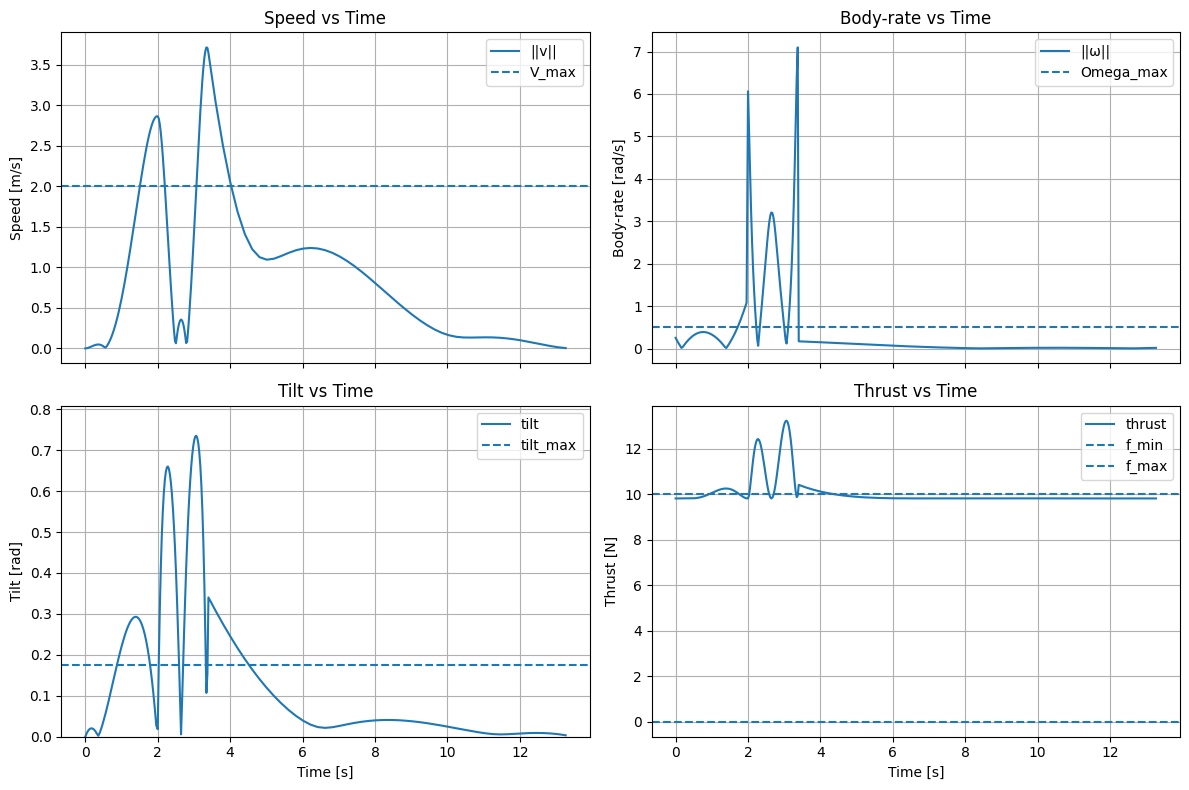

In [9]:
# Get initial guess
list_z0 = plot_initial_setting_main()

pts, vels, accs, jerks, times = eval_traj_and_derivs(list_z0[0], 200)
fig, axs = plot_dyn_from_z_grid(list_z0[0], plot_samples_per_seg, yaw_ref=0.0, tilt_units="rad")

In [10]:
# Scipy solve
# run_single_opt()
# run_multi_opt()

In [11]:
# --- Test: compare closed-form vs numeric (should match very closely) ---
np.random.seed(42)

# Problem size
M = 5           # segments
d = 3           # dimensions
wps = np.cumsum(np.random.randn(M+1, d), axis=0)   # random walk positions

# Positive segment times
T = 0.5 + np.abs(np.random.randn(M))               # (M,)

# Build velocities (fixed) e.g., central differences consistent with time
V = np.zeros_like(wps)
V[0]   = (wps[1]   - wps[0])   / T[0]
V[-1]  = (wps[-1]  - wps[-2])  / T[-1]
for i in range(1, M):
    V[i] = (wps[i+1] - wps[i-1]) / (T[i-1] + T[i])

# End accelerations
a0 = np.zeros(d)
af = np.zeros(d)

# Closed-form
A_cf = solve_minjerk_acc_closedform(wps, T, V, a0, af)

# Numeric (endpoint penalties off so it's the same objective)
A_num = solve_minjerk_acc_only_numeric(
    wps, T, V, a0, af, lambda0=0.0, lambdaT=0.0, quad_N=400, maxiter=500, disp=False
)

# Compare
diff = A_cf - A_num
print("||A_closed - A_numeric||_F =", np.linalg.norm(diff))
print("max |diff| =", np.max(np.abs(diff)))
print("mean |diff| per entry =", np.mean(np.abs(diff)))

# Optional: sanity-check the cost values match as well
def total_jerk_cost(wps, T, V, A, quad_N=500):
    def seg_coeffs(P0, P1, V0, V1, A0, A1, Tr):
        c3 = (-20*P0 + 20*P1 - (8*V1 + 12*V0)*Tr - (3*A0 - A1)*Tr**2) / (2*Tr**3)
        c4 = ( 30*P0 - 30*P1 + (14*V1 + 16*V0)*Tr + (3*A0 - 2*A1)*Tr**2) / (2*Tr**4)
        c5 = (-12*P0 + 12*P1 - (6*V1 +  6*V0)*Tr - (A0   -  A1)*Tr**2) / (2*Tr**5)
        return c3, c4, c5

    tot = 0.0
    M = len(T)
    d = wps.shape[1]
    for r in range(M):
        Tr = max(1e-12, float(T[r]))
        ts = np.linspace(0.0, Tr, quad_N)
        for dim in range(d):
            c3, c4, c5 = seg_coeffs(wps[r, dim], wps[r+1, dim], V[r, dim], V[r+1, dim], A[r, dim], A[r+1, dim], Tr)
            j = 6*c3 + 24*c4*ts + 60*c5*ts**2
            tot += np.trapz(j*j, ts)
    return tot

J_cf  = total_jerk_cost(wps, T, V, A_cf)
J_num = total_jerk_cost(wps, T, V, A_num)
print("J_closed =", J_cf)
print("J_numeric=", J_num)
print("abs diff  =", abs(J_cf - J_num))


||A_closed - A_numeric||_F = 0.00021386227870220394
max |diff| = 0.00015963340930724712
mean |diff| per entry = 2.9905637219164603e-05
J_closed = 2511.8264546563596
J_numeric= 2511.8264544135654
abs diff  = 2.4279415811179206e-07


static const double z0_data[39] = {
  0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 2, 0, -0.050662662931596956, 4.87257505985749, 0, -0.094808548455064326,
  -0.51372833982035027, 0, 0, 4, 0, 1.2695909971048445, 20.878459542727704, 0,
  32.007205070390974, -109.61237615412993, 0, 5, 5, 0, 0, 0,
  0, 0, 0, 0, 0.73205080756887719, 0.34183291757628842, 3.3740550707847063
};

double py_cost=38962.797717491572;
Eigen::VectorXd py_gradient(prototype_solver_ptr->getNumDecisionVariables());
py_gradient << 
0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, -216.314747808777, 23427.219173763511, -7.028109920136, -102.470196836984, 10833.165241272422, 2.849014573552, -7.143723000717, 1194.308615690353, -0.740841338578, 244.820220206900, -24685.640050017631, -1.293869191514, -31.575452670201, 3039.270650175118, 1.202832900445, 2.406450934129, -128.335797118355, 0.126886298017, 0.000000000000, 0.000000000000, 0.0000000

Analytical gradient: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.16314748e+02  2.34272192e+04 -7.02810992e+00
 -1.02470197e+02  1.08331652e+04  2.84901457e+00 -7.14372300e+00
  1.19430862e+03 -7.40841339e-01  2.44820220e+02 -2.46856401e+04
 -1.29386919e+00 -3.15754527e+01  3.03927065e+03  1.20283290e+00
  2.40645093e+00 -1.28335797e+02  1.26886298e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.57461145e+04 -8.08919950e+04 -3.49397134e+04]
Numerical gradient: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.16314947e+02  2.34272198e+04 -7.02821126e+00
 -1.02470221e+02  1.08331652e+04  2.84926500e+00 -7.14389898e+00
  1.19430879e+03 -7.41420081e-01  2.44820694e+02 -2.46856401e+04

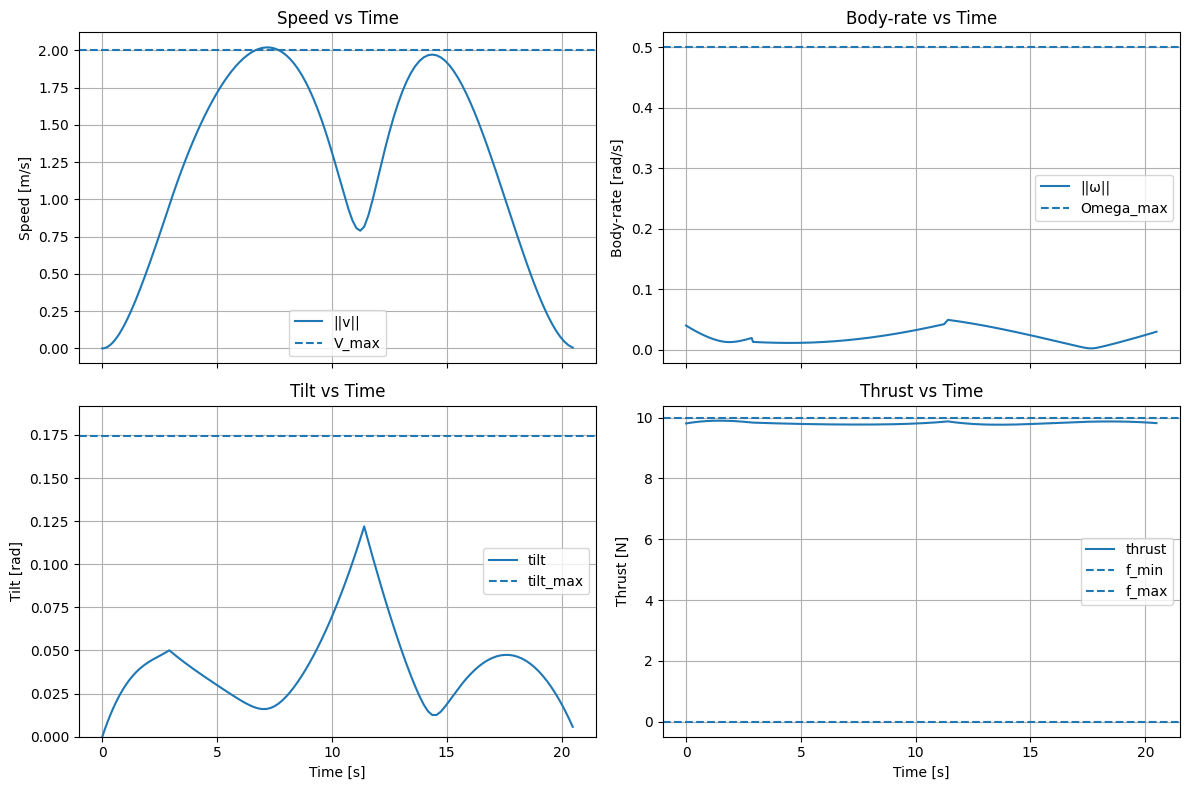

In [263]:
# Custom L-BFGS solver
eigen_map_init("z0", list_z0[0])
optimization_test(list_z0, bfgs_max_iter, visualize=True)

# Gradient test
grad_report(list_z0[0], eps=1e-8)
dot_test(list_z0[0], eps=1e-8)


In [264]:
import numpy as np

# =========================
# Packing / unpacking utils
# =========================

def pack_minco_vars(q, T):
    """
    q: (M-1, 3) array of intermediate positions
    T: (M,) array of positive durations
    -> flat decision vector x
    """
    return np.hstack([q.reshape(-1), T.reshape(-1)])

def unpack_minco_vars(x, num_pieces, dim=3):
    """
    Inverse of pack_minco_vars.
    """
    M = num_pieces
    q = x[: (M-1)*dim].reshape(M-1, dim) if M > 1 else np.zeros((0, dim))
    T = x[(M-1)*dim : (M-1)*dim + M]
    return q, T

# =========================
# Boundary conditions utils
# =========================

def _stack_boundary(bc):
    """
    bc: dict with keys p0,v0,a0,pT,vT,aT (each 3,)
    Returns D0, DM as (s=3, m=3) matrices:
       rows correspond to [pos, vel, acc]; columns to x,y,z.
    """
    p0, v0, a0 = [np.asarray(bc[k]).reshape(3) for k in ("p0", "v0", "a0")]
    pT, vT, aT = [np.asarray(bc[k]).reshape(3) for k in ("pT", "vT", "aT")]
    D0 = np.vstack([p0, v0, a0])  # (3,3)
    DM = np.vstack([pT, vT, aT])  # (3,3)
    return D0, DM

# =========================
# Polynomial basis utilities
# =========================

def _falling_factorial(n, r):
    if r <= 0:
        return 1.0
    prod = 1.0
    for k in range(r):
        prod *= (n - k)
    return prod

def _monomial_derivative_row(N, r, x):
    """
    Row vector of length N+1 with d^r/dx^r [1, x, x^2, ..., x^N] evaluated at x.
    For column coefficients a (length N+1), a^T @ row gives the r-th derivative at x.
    """
    row = np.zeros(N + 1, dtype=float)
    for k in range(r, N + 1):
        row[k] = _falling_factorial(k, r) * (x ** (k - r))
    return row

def _B(N, orders, x):
    """
    Stack derivative rows for derivative orders in 'orders'.
    """
    return np.vstack([_monomial_derivative_row(N, r, x) for r in orders])

# =========================
# MINCO system assembly
# =========================

def _build_blocks(Ti, s=3):
    """
    For internal knot i with d_i=1 (position), s=3 (minimum jerk),
    build E_i, F_i and their d/dTi.
    Shapes: each (2s x 2s) = (6 x 6)
    """
    N = 2*s - 1  # degree 5
    di = 1
    dbar = 2*s - di  # 5

    # E_i rows:
    #  - top di rows:   beta^{(0..di-1)}(Ti) = beta^{(0)}(Ti)
    #  - bottom dbar rows: beta^{(0..dbar-1)}(Ti) = beta^{(0..4)}(Ti)
    Ei_top    = _B(N, [0], Ti)         # (1,6)
    Ei_bottom = _B(N, list(range(0, dbar)), Ti)  # (5,6)
    Ei = np.vstack([Ei_top, Ei_bottom])          # (6,6)

    # F_i rows:
    #  - top di rows: zeros (because only ci is constrained to qi)
    #  - bottom dbar rows: - beta^{(0..4)}(0)
    Fi_top    = np.zeros((di, 2*s))
    Fi_bottom = -_B(N, list(range(0, dbar)), 0.0)
    Fi = np.vstack([Fi_top, Fi_bottom])          # (6,6)

    # dE_i/dTi:
    dEi_top    = _B(N, [1], Ti)                  # derivative w.r.t Ti
    dEi_bottom = _B(N, list(range(1, dbar+1)), Ti)  # (5,6) for orders 1..5
    dEi = np.vstack([dEi_top, dEi_bottom])       # (6,6)

    return Ei, Fi, dEi

def _build_boundary_blocks(TM, s=3):
    """
    F0 (start) and EM (end) blocks.
    F0 * c1 = D0
    EM * cM = DM
    """
    N = 2*s - 1
    F0 = _B(N, list(range(0, s)), 0.0)      # (3,6)
    EM = _B(N, list(range(0, s)), TM)       # (3,6)
    dEM_dTM = _B(N, list(range(1, s+1)), TM)  # d/dTM
    return F0, EM, dEM_dTM

def _assemble_M_and_b(T, q, D0, DM, s=3):
    """
    Assemble global banded system M(T) c = b(q).
    - T: (M,)
    - q: (M-1,3)
    - D0, DM: (3,3)
    Returns:
      M  : (2Ms, 2Ms)
      b  : (2Ms, 3)
      Ei_list: list of (Ei, Fi, dEi) for i=1..M-1
    """
    T = np.asarray(T).reshape(-1)
    M_pieces = len(T)
    m = 3
    Ncoef = 2*s             # 6
    rows_total = 2*s * M_pieces

    Mmat = np.zeros((rows_total, rows_total), dtype=float)
    bmat = np.zeros((rows_total, m), dtype=float)

    # Helper to address column block for piece j (0-based)
    def col_slice(j):
        return slice(j*Ncoef, (j+1)*Ncoef)

    # Row blocks:
    row = 0
    # Start boundary
    F0, _, _ = _build_boundary_blocks(T[-1], s)
    Mmat[row:row+s, col_slice(0)] = F0
    bmat[row:row+s, :] = D0
    row += s

    # Internal knots
    Ei_list = []
    for i in range(1, M_pieces):
        Ti = T[i-1]
        Ei, Fi, dEi = _build_blocks(Ti, s)
        Mmat[row:row+2*s, col_slice(i-1)] = Ei
        Mmat[row:row+2*s, col_slice(i  )] = Fi

        # RHS: [D_i; 0], with D_i = q_i (position only)
        block_rhs = np.zeros((2*s, m))
        if q.shape[0] > 0:
            block_rhs[0, :] = q[i-1, :]  # position at knot i
        bmat[row:row+2*s, :] = block_rhs

        Ei_list.append((Ei, Fi, dEi))
        row += 2*s

    # End boundary
    _, EM, _ = _build_boundary_blocks(T[-1], s)
    Mmat[row:row+s, col_slice(M_pieces-1)] = EM
    bmat[row:row+s, :] = DM
    # row += s  # not used further

    return Mmat, bmat, Ei_list

# =========================
# Jerk energy (per piece)
# =========================

def _jerk_Q(T):
    """
    Q(T) for ∫_0^T (p'''(t))^2 dt in monomial basis up to degree 5.
    Returns 6x6 symmetric matrix.
    Entry (i,j) uses formula:
      if i,j>=3: ff(i,3)*ff(j,3) * T^{i+j-5} / (i+j-5)
      else: 0
      where ff(k,3)=k*(k-1)*(k-2), indices i,j start at 0.
    """
    Q = np.zeros((6,6), dtype=float)
    for i in range(3,6):
        for j in range(3,6):
            num = _falling_factorial(i,3) * _falling_factorial(j,3)
            denom = (i + j - 5)
            Q[i,j] = num * (T ** denom) / denom
    return Q

def _dQdT(T):
    """
    d/dT of Q(T). For i,j>=3:
      d/dT [ff(i,3)ff(j,3)*T^{i+j-5}/(i+j-5)] = ff(i,3)ff(j,3)*T^{i+j-6}
    """
    dQ = np.zeros((6,6), dtype=float)
    for i in range(3,6):
        for j in range(3,6):
            dQ[i,j] = _falling_factorial(i,3)*_falling_factorial(j,3) * (T ** (i + j - 6))
    return dQ

def _cost_grad_wrt_c_and_T(c_flat, T, w):
    """
    Given the solved coefficients c for all pieces (shape (2s*M, 3)),
    compute:
      - Jc: jerk energy
      - dJdc: gradient wrt coefficients (same shape)
      - dJdT_cost: partial derivative wrt each Ti from cost (vector length M)
    """
    c_flat = np.asarray(c_flat)
    T = np.asarray(T).reshape(-1)
    s = 3
    Ncoef = 2*s
    M_pieces = len(T)
    m = 3
    w = np.asarray(w).reshape(m)  # per axis weights

    J = 0.0
    dJdc = np.zeros_like(c_flat)
    dJdT = np.zeros(M_pieces, dtype=float)

    for i in range(M_pieces):
        ci = c_flat[i*Ncoef:(i+1)*Ncoef, :]   # (6,3)
        Q = _jerk_Q(T[i])                     # (6,6)
        # cost contribution
        CiQC = ci.T @ Q @ ci                  # (3,3)
        J += np.sum(w * np.diag(CiQC))        # weights per axis

        # gradient wrt ci: 2 * Q @ (ci * w)
        weighted_ci = ci * w.reshape(1, m)
        dJdc[i*Ncoef:(i+1)*Ncoef, :] = 2.0 * (Q @ weighted_ci)

        # dJ/dTi from cost: sum_d w_d * c_d^T dQ/dT c_d
        dQ = _dQdT(T[i])
        Ci_dQ_Ci = ci.T @ dQ @ ci
        dJdT[i] = np.sum(w * np.diag(Ci_dQ_Ci))

    return J, dJdc, dJdT

# =========================
# Time regularization rho(T)
# =========================

def _rho_value_and_grad(T, rho):
    """
    rho: dict
      - {"type":"none"}
      - {"type":"linear","weight":k}
      - {"type":"quadratic","weight":k,"T_expected":Tsum_expected}
    Returns (rho_value, drho_dT vector)
    """
    T = np.asarray(T).reshape(-1)
    if rho is None or rho.get("type","none") == "none":
        return 0.0, np.zeros_like(T)
    t = rho.get("type","linear").lower()
    if t == "linear":
        k = float(rho.get("weight", 0.0))
        return k * np.sum(T), k * np.ones_like(T)
    elif t == "quadratic":
        k = float(rho.get("weight", 0.0))
        Texp = float(rho.get("T_expected", 0.0))
        s = np.sum(T) - Texp
        return k * s * s, (2.0 * k * s) * np.ones_like(T)
    else:
        raise ValueError(f"Unsupported rho type: {t}")

# =========================
# Public API: objective
# =========================

def evaluate_objective_minco(x, num_pieces, bc, rho=None, w=(1.0,1.0,1.0)):
    """
    Scalar objective for MINCO (minimum jerk + time regularization).
    Decision vector x packs [q(:); T].
      - num_pieces (M) >= 1
      - bc: dict with arrays for p0,v0,a0,pT,vT,aT (each shape (3,))
      - rho: dict (see _rho_value_and_grad)
      - w: weights per axis for jerk cost

    Returns: scalar objective value.
    """
    s = 3
    q, T = unpack_minco_vars(x, num_pieces, dim=3)
    D0, DM = _stack_boundary(bc)

    # Assemble and solve for coefficients
    Mmat, bmat, _ = _assemble_M_and_b(T, q, D0, DM, s=s)
    # Solve M c = b for all 3 axes at once
    c_flat = np.linalg.solve(Mmat, bmat)  # shape (2s*M, 3)

    # Jerk energy
    Jc, _, dJdT_cost = _cost_grad_wrt_c_and_T(c_flat, T, w)

    # Time regularization
    Jr, _ = _rho_value_and_grad(T, rho)

    return float(Jc + Jr)

# =========================
# Public API: analytical gradient
# =========================

def compute_analytical_grad_minco(x, num_pieces, bc, rho=None, w=(1.0,1.0,1.0)):
    """
    Analytical gradient wrt decision vector x = [q(:); T].
    Uses the adjoint formula derived from the banded system M(T)c=b(q):
      dJ/dq_i = [M^{-T} (dJ/dc)]_{row r}   with r = (2i-1)*s  (1-based -> 0-based)
      dJ/dT_i = (dJ/dT_i)|cost+rho - trace(G_i^T (dE_i/dT_i) c_i)
    where G solves M^T G = dJ/dc and G_i is the row block for knot i (size 2s x 3).
    """
    s = 3
    m = 3
    q, T = unpack_minco_vars(x, num_pieces, dim=m)
    D0, DM = _stack_boundary(bc)

    # Assemble
    Mmat, bmat, Ei_list = _assemble_M_and_b(T, q, D0, DM, s=s)
    M_pieces = len(T)
    Ncoef = 2*s

    # Solve for coefficients
    c_flat = np.linalg.solve(Mmat, bmat)  # (2s*M, 3)

    # Cost part: value Jc, grad wrt c and T
    Jc, dJdc, dJdT_cost = _cost_grad_wrt_c_and_T(c_flat, T, w)

    # Time regularization
    Jr, d_rho_dT = _rho_value_and_grad(T, rho)

    # Solve adjoint: M^T G = dJ/dc
    G = np.linalg.solve(Mmat.T, dJdc)  # (2s*M, 3)

    # Gradient wrt q (only at internal knots)
    dJ_dq = np.zeros_like(q)  # (M-1,3)
    for i in range(1, M_pieces):  # internal knots i=1..M-1 (1-based)
        r = (2*i - 1) * s  # (1-based to 0-based row index)
        dJ_dq[i-1, :] = G[r, :]  # pick that row (Eq. (60))

    # Gradient wrt T: cost + rho - trace(G_i^T dEi c_i)
    dJ_dT = dJdT_cost + d_rho_dT

    # Subtract trace terms for internal i = 1..M-1
    # Identify row-block slice for Gi (2s rows each after the first boundary block)
    # Row layout: [F0 (s rows)] , then for each internal knot: [EiFi (2s rows)], finally [EM (s rows)]
    for i in range(1, M_pieces):  # internal knot i
        row_start = s + (i-1)*2*s
        row_end   = row_start + 2*s
        Gi = G[row_start:row_end, :]              # (2s,3)
        dEi = Ei_list[i-1][2]                     # (2s,2s)
        ci = c_flat[(i-1)*Ncoef : i*Ncoef, :]     # coefficients of piece i (left of knot), (6,3)

        # trace(Gi^T dEi ci) = sum over axis diag of (Gi^T dEi ci)
        # Compute small matrix and take trace:
        mat = Gi.T @ (dEi @ ci)   # (3,3)
        tr_val = np.trace(mat)
        dJ_dT[i-1] -= tr_val

    # For completeness: EM depends on TM, but the term from EM cancels through costate conditions;
    # dJ/dT_M already includes cost+rho contribution; no extra EM term is needed here per Eq. (68).

    # Pack gradient back into shape of x
    grad = np.zeros_like(x)
    if M_pieces > 1:
        grad[: (M_pieces-1)*m] = dJ_dq.reshape(-1)
    grad[(M_pieces-1)*m : (M_pieces-1)*m + M_pieces] = dJ_dT
    return grad


In [266]:
# Define a simple problem
M = 3  # number of pieces
bc = {
    "p0": np.array([0,0,0]), "v0": np.zeros(3), "a0": np.zeros(3),
    "pT": np.array([3,0,0]), "vT": np.zeros(3), "aT": np.zeros(3),
}
q0 = np.array([[1,0,0], [2,0,0]])  # (M-1, 3)
T0 = np.array([1.0, 1.0, 1.0])     # (M,)

x0 = pack_minco_vars(q0, T0)

rho = {"type":"linear","weight":1e-2}
w = (1.0, 1.0, 1.0)

# Objective
J = evaluate_objective_minco(x0, M, bc, rho=rho, w=w)

# Gradient
g = compute_analytical_grad_minco(x0, M, bc, rho=rho, w=w)

# Solve the optimization problem with scipy.optimize.minimize
from scipy.optimize import minimize
result = minimize(
    fun=lambda x: evaluate_objective_minco(x, M, bc, rho=rho, w=w),
    x0=x0,
    method='L-BFGS-B',
    options={'disp': True}
)
print("Optimization result:", result)



Optimization result:   message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.14597284789855075
        x: [ 5.420e-01 -3.672e-07 -3.672e-07  2.458e+00  3.222e-07
             3.222e-07  3.807e+00  4.550e+00  3.807e+00]
      nit: 23
      jac: [ 1.998e-06 -3.580e-07 -3.580e-07 -2.004e-06  3.525e-07
             3.525e-07 -1.776e-07  5.052e-07 -1.776e-07]
     nfev: 240
     njev: 24
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
